<a href="https://colab.research.google.com/github/Giovo17/cardio-disease-analysis/blob/main/cardio_disease_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cardio disease analysis

In [1]:
# Importing main libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay


plt.rcParams.update({'figure.figsize': (10.0, 10.0)})
plt.rcParams.update({'font.size': 12})
#plt.rcParams.update({'figure.dpi': 300})

In [2]:
data_source = "https://raw.githubusercontent.com/Giovo17/cardio-disease-analysis/main/cardio_train.csv"
df = pd.read_csv(data_source, sep=";", index_col="id")

In [3]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


#### Data description reported by authors

There are 3 types of input features:

1. Objective: factual information;
2. Examination: results of medical examination;
3. Subjective: information given by the patient.


| Feature | Feature type | Name in dataset | Data type
| :---: | :-------------------: | :-----: | :-----------: |
|Age | Objective Feature | age | int (days)|
|Height | Objective Feature | height | int (cm) |
|Weight | Objective Feature | weight | float (kg) |
|Gender | Objective Feature | gender | categorical code (1: women, 2: men) |
|Systolic blood pressure | Examination Feature | ap_hi | int |
|Diastolic blood pressure | Examination Feature | ap_lo | int |
|Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
|Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
|Smoking | Subjective Feature | smoke | binary |
|Alcohol intake | Subjective Feature | alco | binary |
|Physical activity | Subjective Feature | active | binary |
|Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [5]:
df["gender"] = df["gender"].map({1: 0, 2: 1})

Add the BMI feature from height and weight

In [6]:
BMI = df["weight"] / (df["height"] / 100)**2
df.insert (4, "BMI", BMI)

Convert age in years

In [7]:
df["age"] = (df["age"]/365).astype(int)

In [8]:
df.head()

,age,gender,height,weight,BMI,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,,
0,50,1,168,62.0,21.967120,110,80,1,1,0,0,1,0
1,55,0,156,85.0,34.927679,140,90,3,1,0,0,1,1
2,51,0,165,64.0,23.507805,130,70,3,1,0,0,0,1
3,48,1,169,82.0,28.710479,150,100,1,1,0,0,1,1
4,47,0,156,56.0,23.011177,100,60,1,1,0,0,0,0


Filter dataset by $BMI \geq 18.5$

In [9]:
#df = df.loc[BMI >= 18.5]

Search for duplicated rows

In [10]:
print("Duplicate rows: {}".format(df.duplicated().sum()))
df = df.drop_duplicates()

Duplicate rows: 3208


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66792 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          66792 non-null  int32  
 1   gender       66792 non-null  int64  
 2   height       66792 non-null  int64  
 3   weight       66792 non-null  float64
 4   BMI          66792 non-null  float64
 5   ap_hi        66792 non-null  int64  
 6   ap_lo        66792 non-null  int64  
 7   cholesterol  66792 non-null  int64  
 8   gluc         66792 non-null  int64  
 9   smoke        66792 non-null  int64  
 10  alco         66792 non-null  int64  
 11  active       66792 non-null  int64  
 12  cardio       66792 non-null  int64  
dtypes: float64(2), int32(1), int64(10)
memory usage: 6.9 MB


## Data exploration and cleaning

### Categorical data

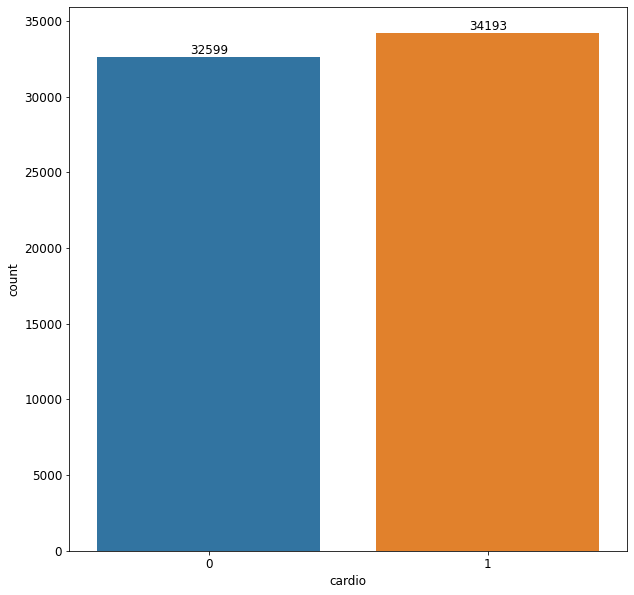

In [12]:
ax = sns.countplot(data=df, x="cardio")
ax.bar_label(ax.containers[0])
plt.show()

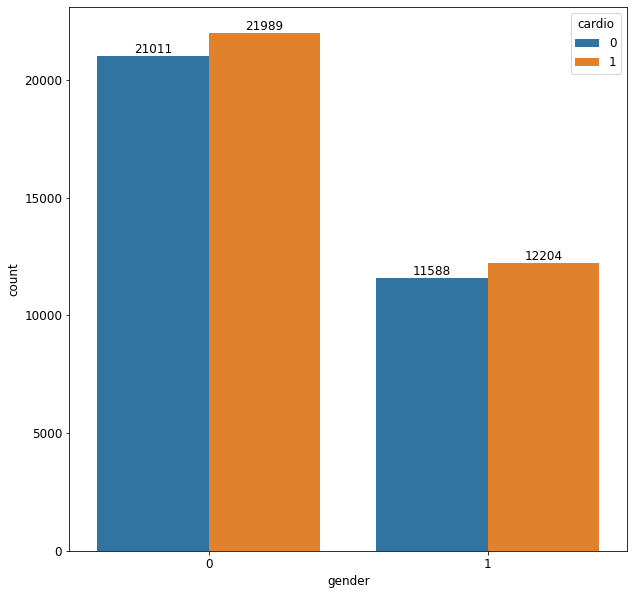

In [13]:
ax = sns.countplot(data=df, x="gender", hue="cardio")
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

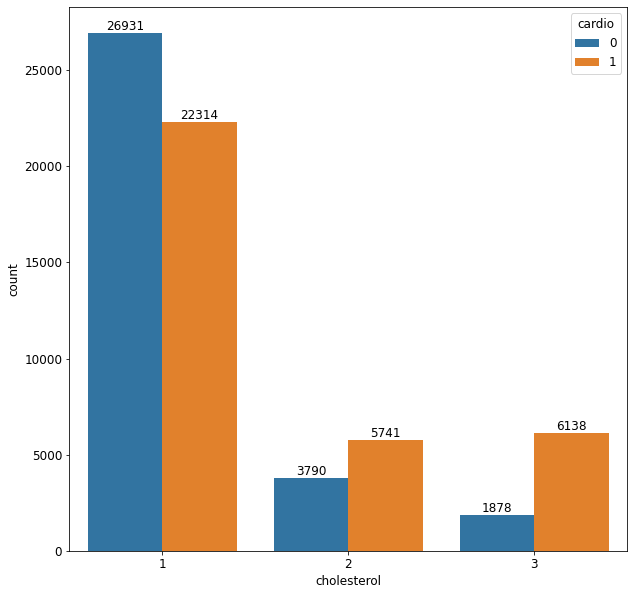

In [14]:
ax = sns.countplot(data=df, x="cholesterol", hue="cardio")
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

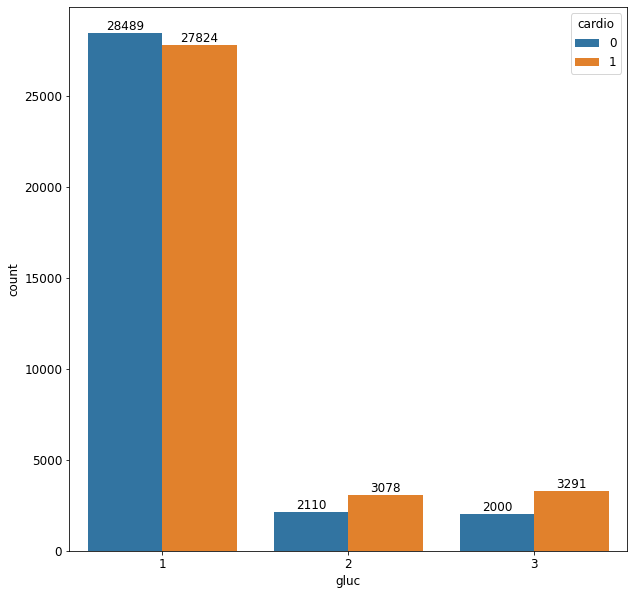

In [15]:
ax = sns.countplot(data=df, x="gluc", hue="cardio")
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

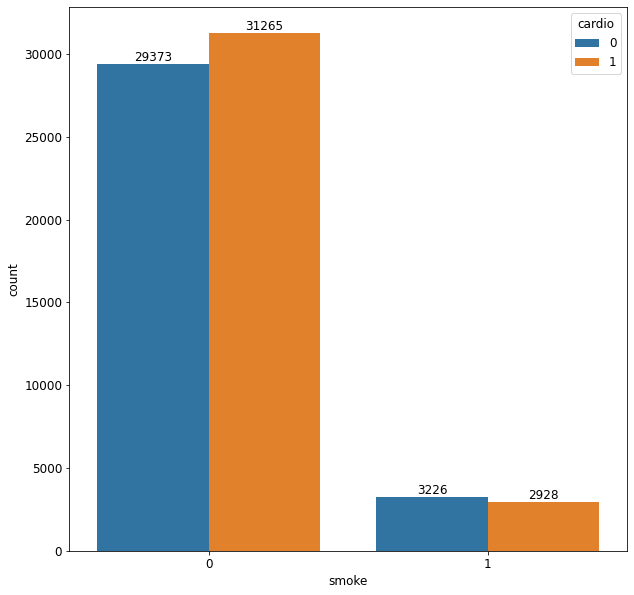

In [16]:
ax = sns.countplot(data=df, x="smoke", hue="cardio")
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

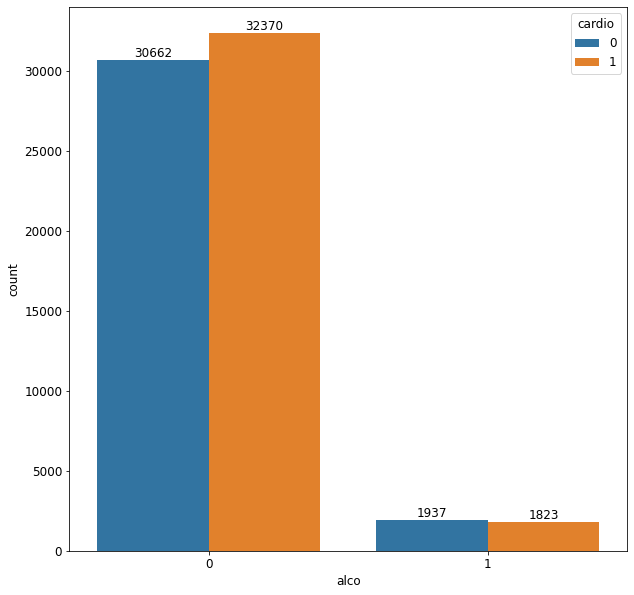

In [17]:
ax = sns.countplot(data=df, x="alco", hue="cardio")
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

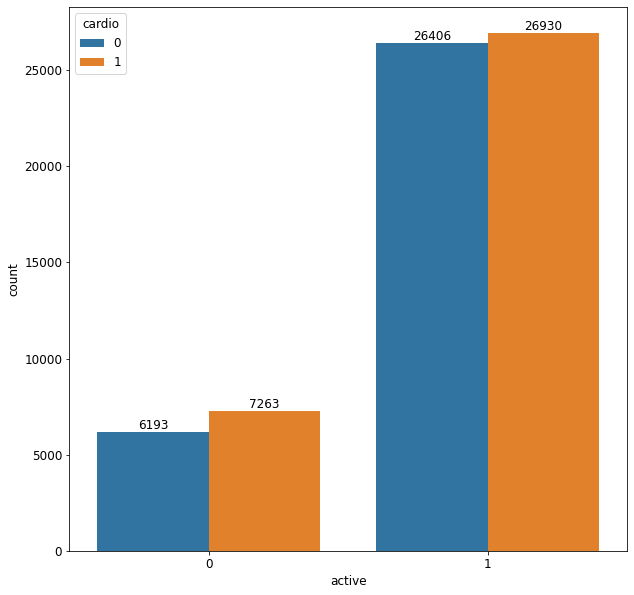

In [18]:
ax = sns.countplot(data=df, x="active", hue="cardio")
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

### Numerical data

**Age**

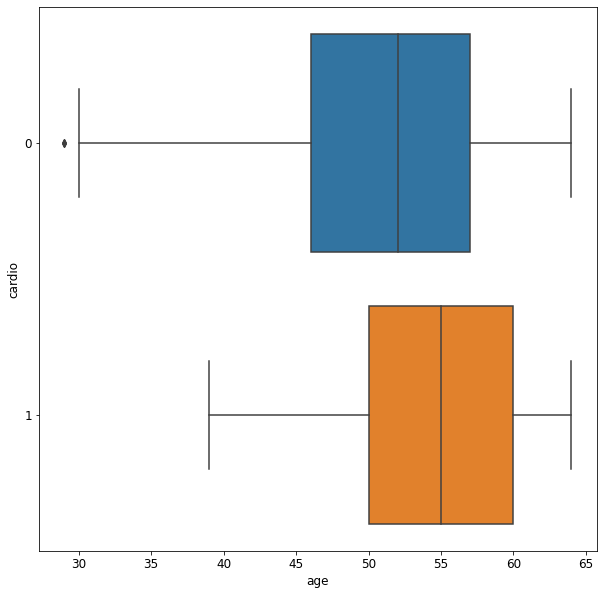

,count,mean,std,min,25%,50%,75%,max
cardio,,,,,,,,
0,32599.0,51.220191,6.847514,29.0,46.0,52.0,57.0,64.0
1,34193.0,54.422835,6.380788,39.0,50.0,55.0,60.0,64.0


In [19]:
sns.boxplot(data=df, x="age", y="cardio", orient="h")
plt.show()

df.groupby("cardio")["age"].describe()

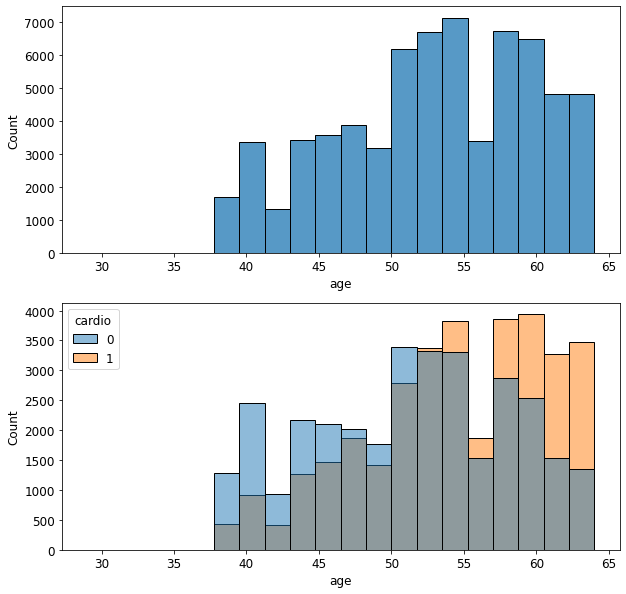

In [20]:
plt.subplot(2, 1, 1)
sns.histplot(data=df, x="age", bins=20)

plt.subplot(2, 1, 2)
sns.histplot(data=df, x="age", bins=20, hue="cardio")

plt.show()

The patients age ranges from 29 to 64, so there are only adults.

The distribution seems to be bimodal with modes around 55 and 58.

Taking into consideration the conditional boxplot this feature is slightly related to the target variable, in fact the "cardio affected" patients box is has higher minimum, 1° quartile, median and 3° quartile with respect to healthy patients. Observing the conditional histplot this trend is confirmed: there's an higher concentration of unhealthy patients as the age increases. Though in both there's a considerable overlap between the two classes.

**Height, weight and BMI**

The BMI is the Body Mass Index and it's defined as $ BMI = \frac{w}{h^2} $ where $w$ is the weight in *kilograms* and $h$ is the height in *meters*

A reference table from [Ministero della salute](https://www.salute.gov.it/portale/nutrizione/dettaglioIMCNutrizione.jsp?lingua=italianoid=5479area=nut):

|Condition|BMI|
|---------|:-:|
| Severe thinness | BMI < 16 |
| Underweight | 16 < BMI < 18.49 |
| Normal weight | 18.5 < BMI < 24.99 |
| Overweight | 25 < BMI < 29.99 |
| Obese class 1 | 30 < BMI < 34.99 |
| Obese class 2 | 35 < BMI < 39.99 |
| Obese class 3 | BMI > 40 |

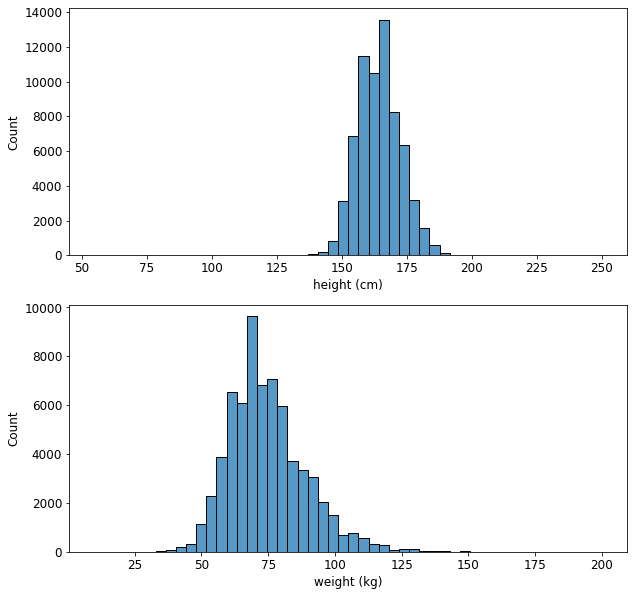

In [21]:
plt.subplot(2, 1, 1)
ax = sns.histplot(data=df, x="height", bins=50)
ax.set_xlabel("height (cm)")

plt.subplot(2, 1, 2)
ax = sns.histplot(data=df, x="weight", bins=50)
ax.set_xlabel("weight (kg)")

plt.show()

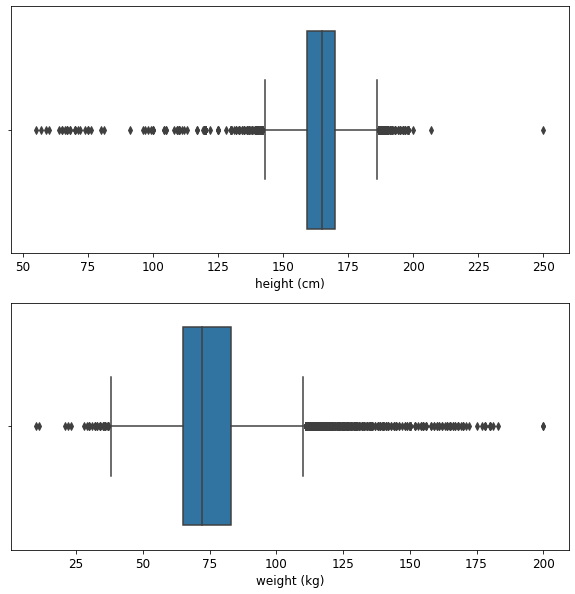

In [22]:
plt.subplot(2, 1, 1)
ax = sns.boxplot(data=df, x="height")
ax.set_xlabel("height (cm)")

plt.subplot(2, 1, 2)
ax = sns.boxplot(data=df, x="weight")
ax.set_xlabel("weight (kg)")

plt.show()

In [23]:
pd.DataFrame(df["height"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.999])).T

,count,mean,std,min,1%,25%,50%,75%,99.9%,max
height,66792.0,164.341748,8.333904,55.0,146.0,159.0,165.0,170.0,190.0,250.0


In [24]:
pd.DataFrame(df["weight"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.999])).T

,count,mean,std,min,1%,25%,50%,75%,99.9%,max
weight,66792.0,74.52116,14.580675,10.0,48.0,65.0,72.0,83.0,150.0,200.0


Both height and weight are unimodal distributions with modes around 165 (cm) and 65 (kg) respectively.

The height distribution looks like it isn't skewed. The weight distribution seems to be slightly positive skewed as it's right tail it's a bit longer than the left one.

These features present outliers as it can be seen from the boxplot and the correspondig statistics table.

Checking weight skeweness:

In [25]:
print("Mode: {}, median: {}, mean: {}".format(stats.mode(df["weight"])[0][0], np.median(df["weight"]), round(np.mean(df["weight"]), 2)))
print("Fisher-Pearson coefficient of skewness: {}".format(round(stats.skew(df["weight"]), 2)))


Mode: 70.0, median: 72.0, mean: 74.52
Fisher-Pearson coefficient of skewness: 0.97


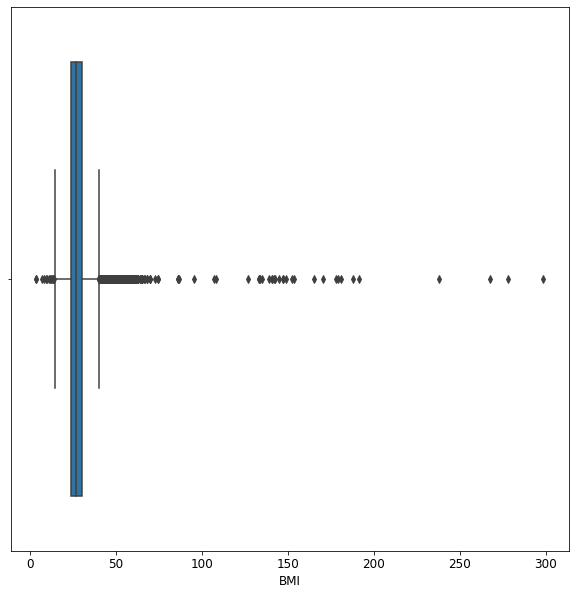

,count,mean,std,min,25%,50%,75%,99.9%,max
BMI,66792.0,27.682565,6.184422,3.471784,23.875115,26.573129,30.46875,59.623333,298.666667


In [26]:
sns.boxplot(data=df, x="BMI")
plt.show()

pd.DataFrame(df["BMI"].describe(percentiles=[0.25, 0.5, 0.75, 0.999])).T

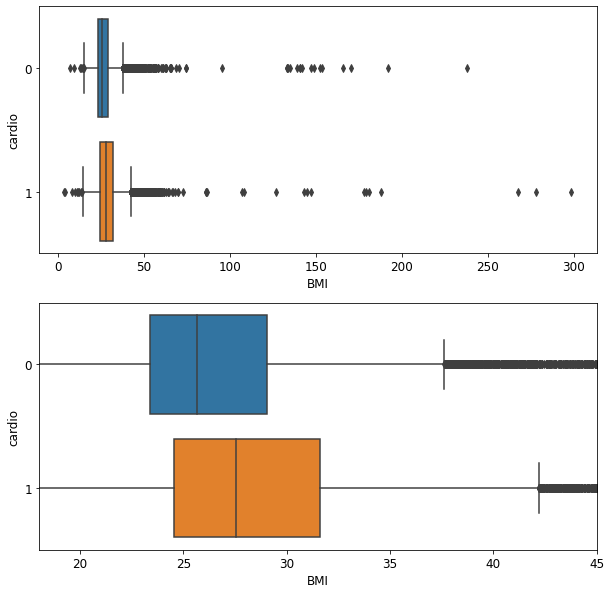

,count,mean,std,min,25%,50%,75%,99.9%,max
cardio,,,,,,,,,
0,32599.0,26.674952,5.755386,7.022248,23.372576,25.636917,29.060607,60.089236,237.768633
1,34193.0,28.643205,6.421927,3.471784,24.560326,27.548209,31.615793,59.458581,298.666667


In [27]:
plt.subplot(2, 1, 1)
sns.boxplot(data=df, x="BMI", y="cardio", orient="h")

plt.subplot(2, 1, 2)
ax = sns.boxplot(data=df, x="BMI", y="cardio", orient="h")
ax.set_xlim(18, 45)

plt.show()

df.groupby("cardio")["BMI"].describe(percentiles=[0.25, 0.5, 0.75, 0.999])

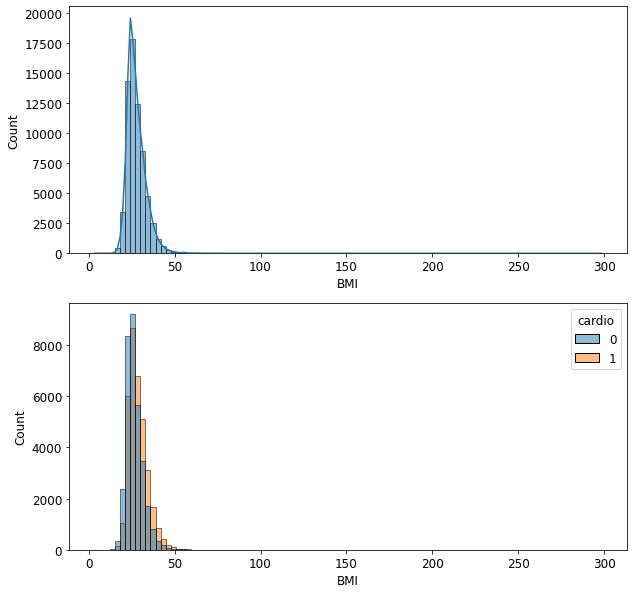

In [28]:
plt.subplot(2, 1, 1)
sns.histplot(data=df, x="BMI", bins=100, kde=True)

plt.subplot(2, 1, 2)
sns.histplot(data=df, x="BMI", bins=100, hue="cardio")

plt.show()

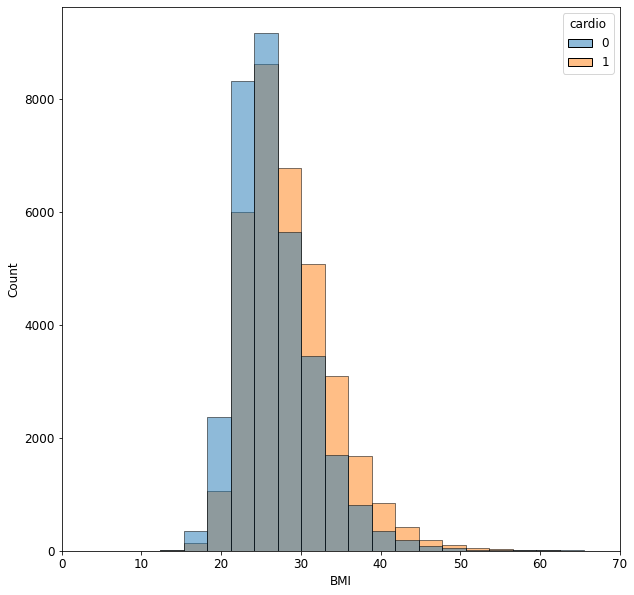

In [29]:
ax = sns.histplot(data=df, x="BMI", bins=100, hue="cardio")
ax.set_xlim(0, 70)
plt.show()

In [30]:
print("Mode: {}, median: {}, mean: {}".format(round(stats.mode(df["BMI"])[0][0], 2), round(np.median(df["BMI"]), 2), round(np.mean(df["BMI"]), 2)))
print("Fisher-Pearson coefficient of skewness: {}".format(round(stats.skew(df["BMI"]), 2)))

Mode: 23.88, median: 26.57, mean: 27.68
Fisher-Pearson coefficient of skewness: 7.69


The BMI feature is unimodal (mode in 23.88) and positively skewed as shown by the Fisher-Pearson coefficient.

There are a lot of outliers in this features.

**Systolic blood pressure (ap_hi) and diastolic blood pressure (ap_lo)**

These features measures the pressure in arteries respectively when the heart beats and in a period between two heatbeats.

A reference table from [heart.org](https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings):

|Blood pressure category|Systolic blood pressure (mm Hg)|and/or|Diastolic blood pressure (mm Hg)|
|-----------------------|:-----------------------------:|:------:|:------------------------------:|
|Normal| ap_hi < 120 | and| ap_lo < 80 |
|Elevated| 120 < ap_hi < 129 | and | ap_lo < 80 |
|High blood pressure (Hypertension stage 1)| 130 < ap_hi < 139 | or | 80 < ap_hi < 89 |
|High blood pressure (Hypertension stage 2)| ap_hi > 140 | or | ap_lo > 90
|Hypertensive crisis| ap_hi > 180 | and/or | ap_lo > 120 |


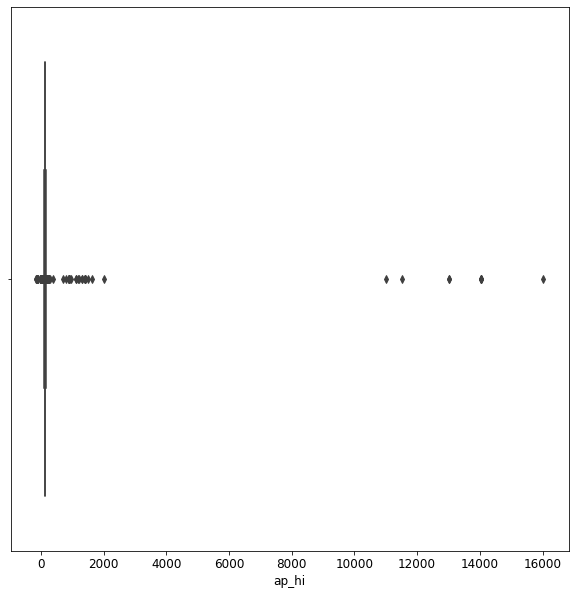

,count,mean,std,min,1%,25%,50%,75%,99.9%,max
ap_hi,66792.0,129.231585,157.649354,-150.0,90.0,120.0,120.0,140.0,220.0,16020.0


In [31]:
ax = sns.boxplot(data=df, x="ap_hi")
plt.show()

pd.DataFrame(df["ap_hi"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.999])).T

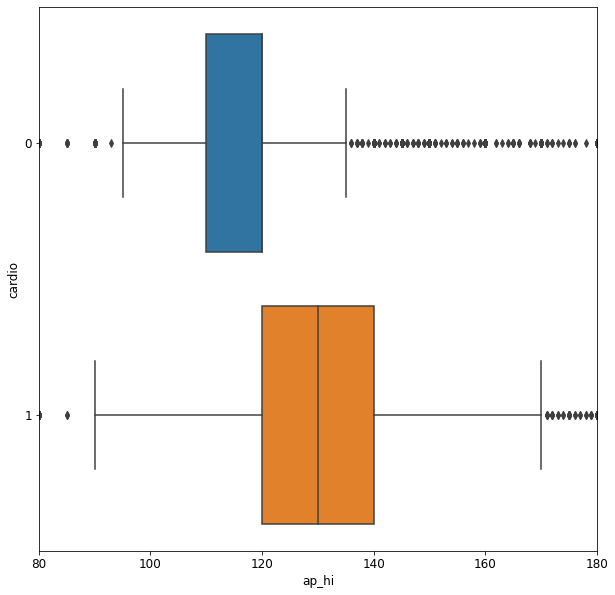

,count,mean,std,min,1%,25%,50%,75%,99%,max
cardio,,,,,,,,,,
0,32599.0,120.528728,107.320611,-120.0,90.0,110.0,120.0,120.0,160.0,14020.0
1,34193.0,137.528734,193.460336,-150.0,100.0,120.0,130.0,140.0,180.0,16020.0


In [32]:
ax = sns.boxplot(data=df, x="ap_hi", y="cardio", orient="h")
ax.set_xlim(80, 180)
plt.show()

df.groupby("cardio")["ap_hi"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

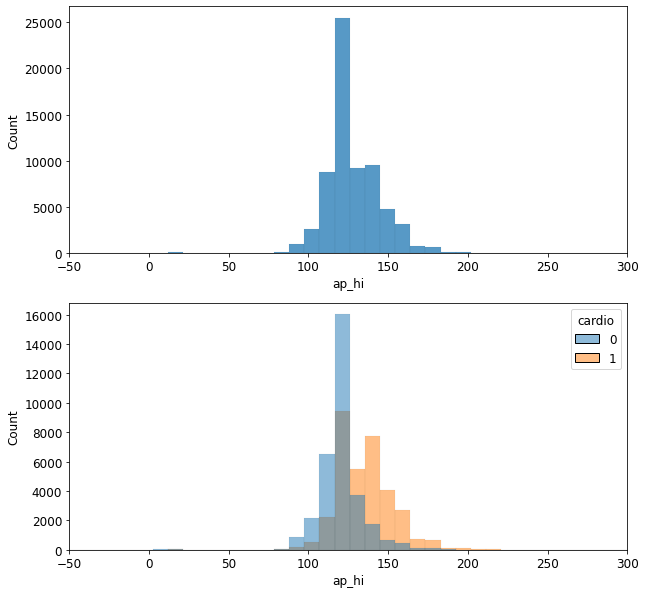

In [33]:
plt.subplot(2, 1, 1)
ax = sns.histplot(data=df, x="ap_hi", bins=1700)
ax.set_xlim(-50, 300)

plt.subplot(2, 1, 2)
ax = sns.histplot(data=df, x="ap_hi", bins=1700, hue="cardio")
ax.set_xlim(-50, 300)

plt.show()

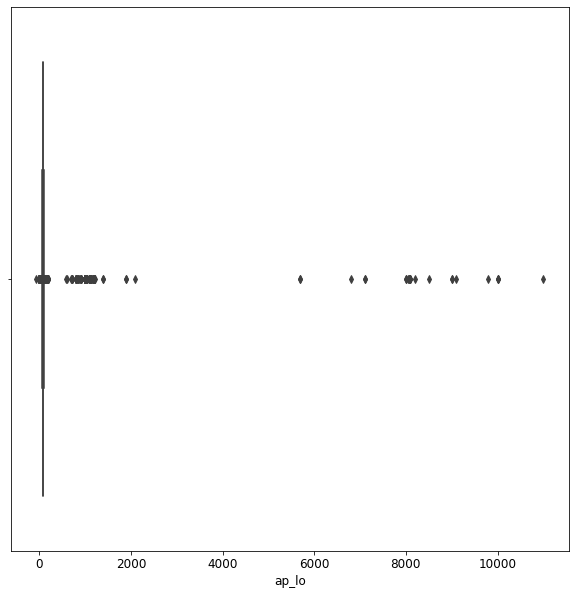

,count,mean,std,min,1%,25%,50%,75%,99.9%,max
ap_lo,66792.0,97.446221,192.906434,-70.0,60.0,80.0,80.0,90.0,1110.0,11000.0


In [34]:
ax = sns.boxplot(data=df, x="ap_lo")
plt.show()

pd.DataFrame(df["ap_lo"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.999])).T

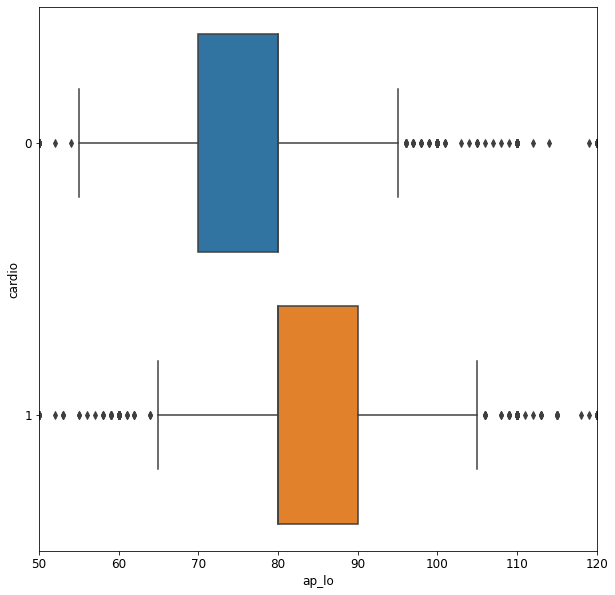

,count,mean,std,min,1%,25%,50%,75%,99%,max
cardio,,,,,,,,,,
0,32599.0,84.634743,158.248448,0.0,60.0,70.0,80.0,80.0,100.0,9800.0
1,34193.0,109.660457,220.252704,-70.0,60.0,80.0,80.0,90.0,1000.0,11000.0


In [35]:
ax = sns.boxplot(data=df, x="ap_lo", y="cardio", orient="h")
ax.set_xlim(50, 120)
plt.show()

df.groupby("cardio")["ap_lo"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

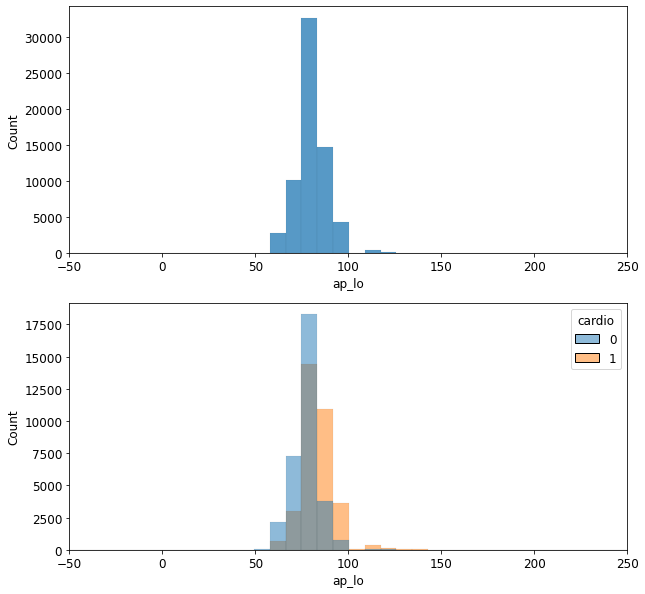

In [36]:
plt.subplot(2, 1, 1)
ax = sns.histplot(data=df, x="ap_lo", bins=1300)
ax.set_xlim(-50, 250)

plt.subplot(2, 1, 2)
ax = sns.histplot(data=df, x="ap_lo", bins=1300, hue="cardio")
ax.set_xlim(-50, 250)

plt.show()

These features have a similar behaviour. Both of them present outliers as it can be seen from the boxplots.

When not considering outliers, they are unimodal (mode around 120 mmHg and 80 mmHg respectively) and approximatevely simmetric. They are related to the cardio feature as it can be seen from the boxplot and the histogram, though there's overlap between healthy and unhealthy patients.

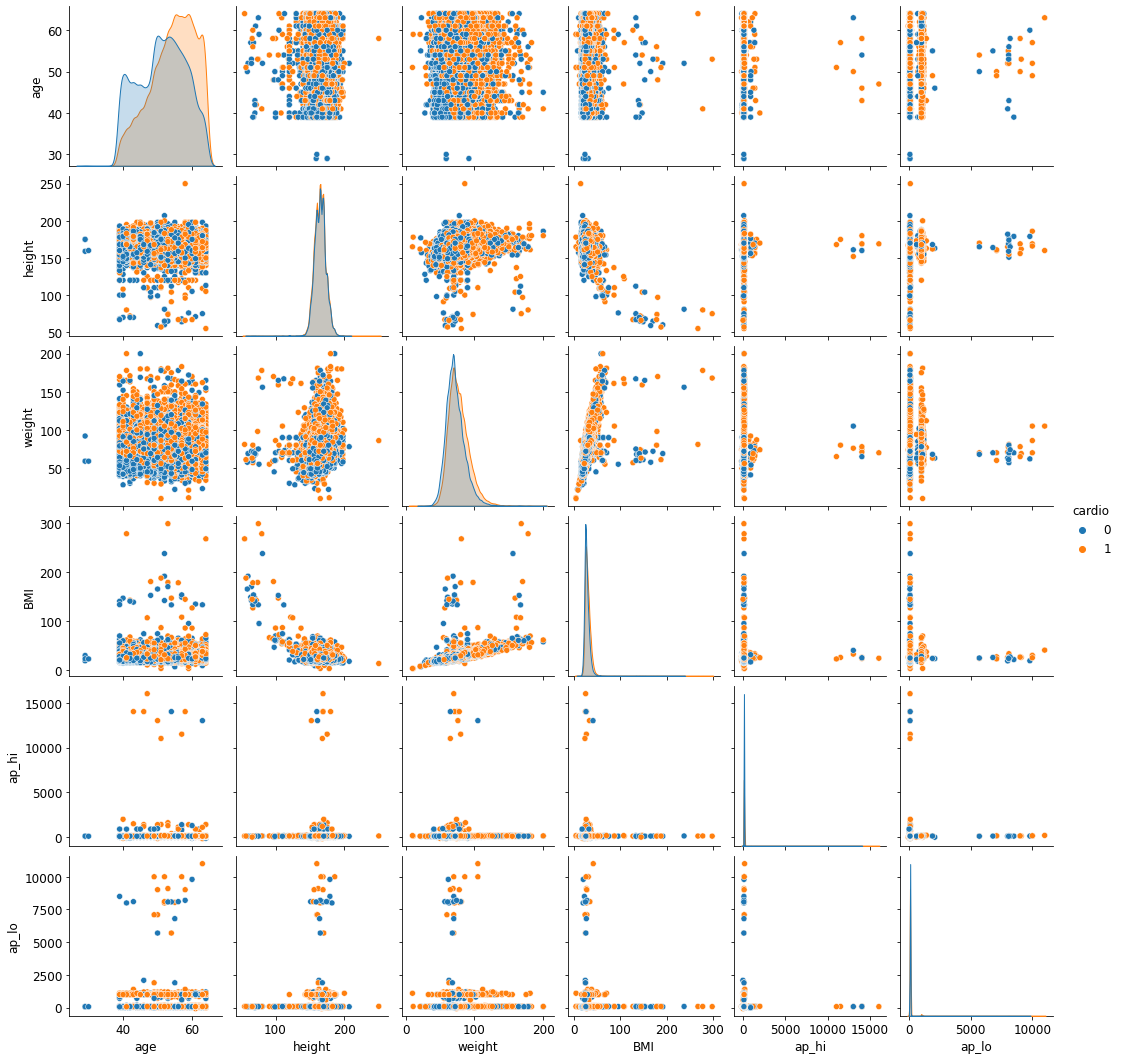

In [37]:
sns.pairplot(data=df[["age", "height", "weight", "BMI", "ap_hi", "ap_lo", "cardio"]], hue='cardio')
plt.show()

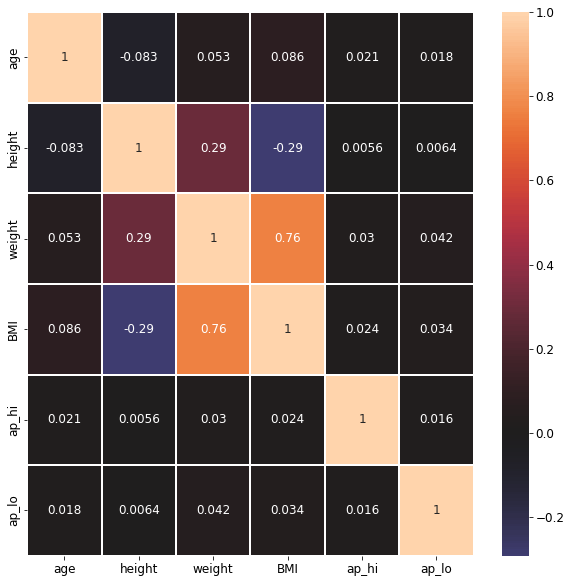

In [38]:
sns.heatmap(df[["age", "height", "weight", "BMI", "ap_hi", "ap_lo"]].corr(), annot=True, fmt=".2g", linewidths=.1, center=0)
plt.show()

**Analizing relationship between ap_hi and ap_lo**

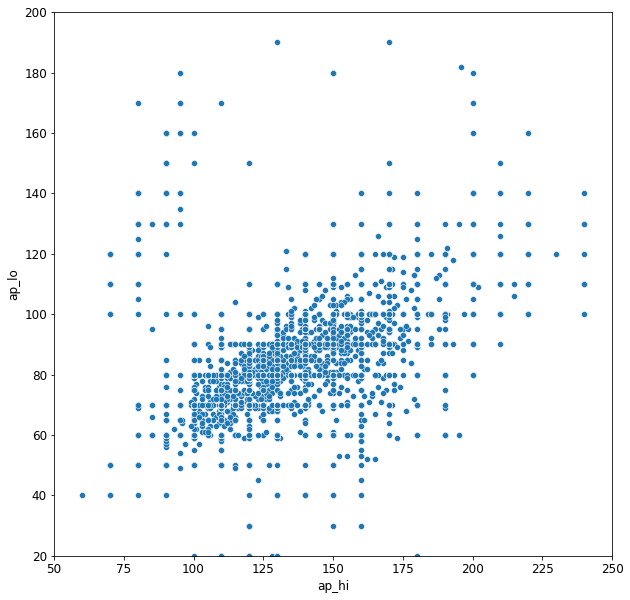

In [37]:
ax = sns.scatterplot(data=df, x="ap_hi", y="ap_lo")
ax.set_xlim(50, 250)
ax.set_ylim(20, 200)

plt.show()

In [38]:
# removing ap_hi and ap_lo outliers
df_cleaned = df[df.ap_hi > 50]
df_cleaned = df_cleaned[df_cleaned.ap_hi < 250]
df_cleaned = df_cleaned[df_cleaned.ap_lo > 20]
df_cleaned = df_cleaned[df_cleaned.ap_lo < 150]

print("Original dataset: {}".format(round(np.corrcoef(df["ap_hi"], df["ap_lo"])[0][1], 3)))
print("Dataset without outliers: {}".format(round(np.corrcoef(df_cleaned["ap_hi"], df_cleaned["ap_lo"])[0][1], 3)))

display(df.shape)
display(df_cleaned.shape)


Original dataset: 0.016
Dataset without outliers: 0.707


(66792, 13)

(65547, 13)

As it can be seen from the scatterplot the two variables that represent the patient blood pressure are very correlated, but this correlation is hidden in the original data due to outliers presence.

**Analizing relationship between BMI, weight and height**

In [39]:
# removing ap_hi and ap_lo outliers
df_cleaned = df_cleaned[df_cleaned.height > 147]
df_cleaned = df_cleaned[df_cleaned.weight > 50]

display(df.shape)
display(df_cleaned.shape)

(66792, 13)

(63365, 13)

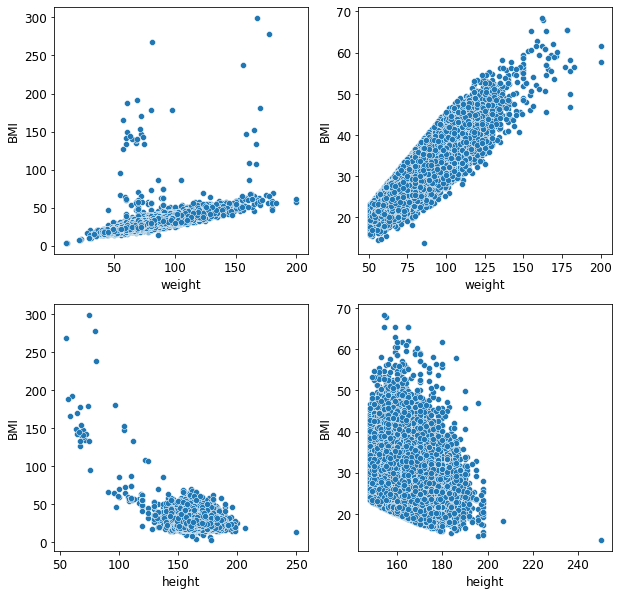

In [40]:
plt.subplot(2, 2, 1)
sns.scatterplot(data=df, x="weight", y="BMI")
plt.subplot(2, 2, 2)
sns.scatterplot(data=df_cleaned, x="weight", y="BMI")
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x="height", y="BMI")
plt.subplot(2, 2, 4)
sns.scatterplot(data=df_cleaned, x="height", y="BMI")

plt.show()

## Data visualization

### PCA

In [41]:
df.head()

,age,gender,height,weight,BMI,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,,
0,50,1,168,62.0,21.967120,110,80,1,1,0,0,1,0
1,55,0,156,85.0,34.927679,140,90,3,1,0,0,1,1
2,51,0,165,64.0,23.507805,130,70,3,1,0,0,0,1
3,48,1,169,82.0,28.710479,150,100,1,1,0,0,1,1
4,47,0,156,56.0,23.011177,100,60,1,1,0,0,0,0


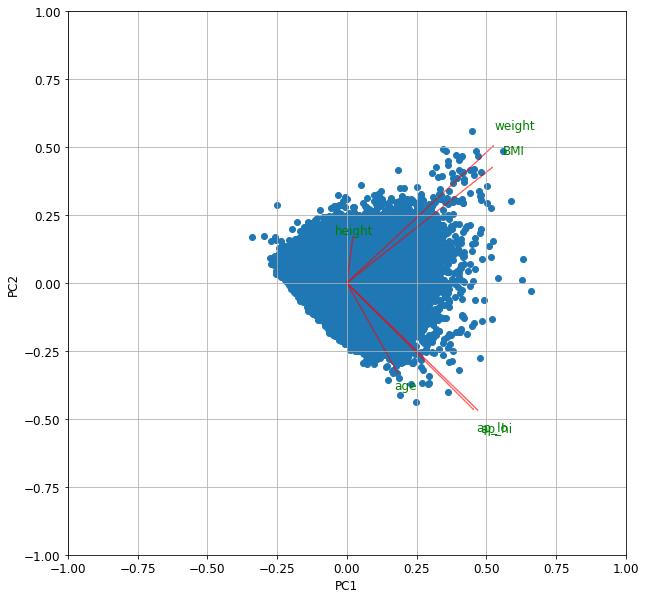

In [42]:
scaler = StandardScaler()
scaler.fit(df_cleaned[["age", "height", "weight", "BMI", "ap_hi", "ap_lo"]])
df_1 = scaler.transform(df_cleaned[["age", "height", "weight", "BMI", "ap_hi", "ap_lo"]])

pca = PCA(n_components=2)
df_1_reduced = pca.fit_transform(df_1)

def biplot(score, coeff, labels=["age", "height", "weight", "BMI", "ap_hi", "ap_lo"]):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    plt.scatter(xs * scalex, ys * scaley) # Display data points
    
    # Diplay arrows and labels
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r', alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var" + tr(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    
    # Plot settings
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
biplot(df_1_reduced[:,0:2], np.transpose(pca.components_[0:2, :]))
plt.show()

In [43]:
display(pca.explained_variance_ratio_)

array([0.38709199, 0.22292877])

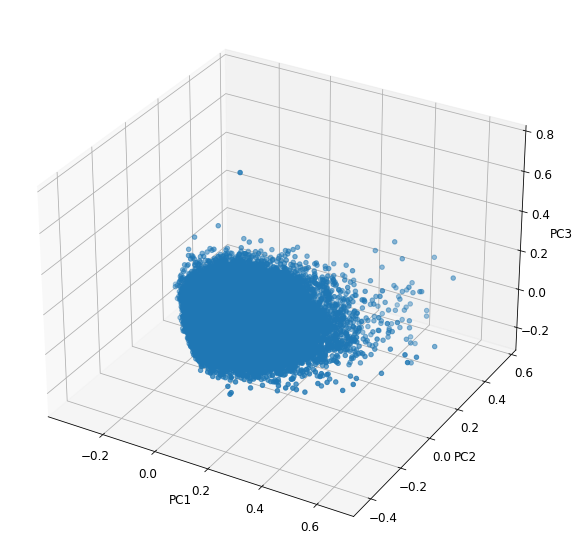

In [44]:
scaler = StandardScaler()
scaler.fit(df_cleaned[["age", "height", "weight", "BMI", "ap_hi", "ap_lo"]])
df_1 = scaler.transform(df_cleaned[["age", "height", "weight", "BMI", "ap_hi", "ap_lo"]])

pca = PCA(n_components=3)
df_1_reduced = pca.fit_transform(df_1)

def biplot(score, coeff, labels=["age", "height", "weight", "BMI", "ap_hi", "ap_lo"]):
    xs = score[:,0]
    ys = score[:,1]
    zs = score[:,2]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    scalez = 1.0/(zs.max() - zs.min())
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(xs * scalex, ys * scaley, zs * scalez)
    '''
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, coeff[i,2] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, coeff[i,2] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    
    
    ax.xlim(-1,1)
    ax.ylim(-1,1)
    ax.zlim(-1,1)
    '''
    
    ax.set_xlabel("PC{}".format(1))
    ax.set_ylabel("PC{}".format(2))
    ax.set_zlabel("PC{}".format(3))
    ax.grid()

#Call the function. Use only the 3 PCs.
biplot(df_1_reduced[:,0:3], np.transpose(pca.components_[0:3, :]))

plt.show()

In [45]:
display(pca.explained_variance_ratio_)

array([0.38709199, 0.22292877, 0.19317576])

## Data preprocessing

In [46]:
for col in df_cleaned.columns:
    if col != "id" and col != "cardio":
        print("Variance of {}: {}".format(col, np.var(df_cleaned[col])))

Variance of age: 46.13787588898139
Variance of gender: 0.23144015710745403
Variance of height: 58.336760020607336
Variance of weight: 196.20830143692595
Variance of BMI: 26.371742929706052
Variance of ap_hi: 286.58291970696524
Variance of ap_lo: 93.38053992002502
Variance of cholesterol: 0.47671952683386054
Variance of gluc: 0.3410574618167164
Variance of smoke: 0.08487798129786009
Variance of alco: 0.05382363227467102
Variance of active: 0.16153682157540133


One hot encoding cholesterol and glucose features

In [47]:
encoder = OneHotEncoder()
onehotarray = encoder.fit_transform(df_cleaned[["cholesterol"]]).toarray()
items = [f'{"cholesterol"}_{item}' for item in encoder.categories_[0]]
df_cleaned[items] = onehotarray

onehotarray = encoder.fit_transform(df_cleaned[["gluc"]]).toarray()
items = [f'{"gluc"}_{item}' for item in encoder.categories_[0]]
df_cleaned[items] = onehotarray

df_cleaned = df_cleaned.drop(columns=["cholesterol", "gluc"])

Scaling datasets

In [48]:
scaler = StandardScaler()
scaler.fit(df[["age", "height", "weight", "BMI", "ap_hi", "ap_lo"]])
df[["age", "height", "weight", "BMI", "ap_hi", "ap_lo"]] = scaler.transform(df[["age", "height", "weight", "BMI", "ap_hi", "ap_lo"]])

scaler.fit(df_cleaned[["age", "height", "weight", "BMI", "ap_hi", "ap_lo"]])
df_cleaned[["age", "height", "weight", "BMI", "ap_hi", "ap_lo"]] = scaler.transform(df_cleaned[["age", "height", "weight", "BMI", "ap_hi", "ap_lo"]])


In [49]:
df_cleaned.head()

,age,gender,height,weight,BMI,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,,
0,-0.419629,1,0.414559,-0.936997,-1.115896,-1.012136,-0.161088,0,0,1,0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.316478,0,-1.156564,0.704988,1.407901,0.759996,0.873749,0,0,1,1,0.0,0.0,1.0,1.0,0.0,0.0
2,-0.272408,0,0.021778,-0.794215,-0.815880,0.169285,-1.195924,0,0,0,1,0.0,0.0,1.0,1.0,0.0,0.0
3,-0.714072,1,0.545486,0.490816,0.197232,1.350707,1.908586,0,0,1,1,1.0,0.0,0.0,1.0,0.0,0.0
4,-0.861294,0,-1.156564,-1.365341,-0.912588,-1.602847,-2.230761,0,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0


## Predictive analysis

Train test split

In [50]:
#dividing the dataset into two sets: train set and test set
def tt_split(dataframe):
  x = dataframe.loc[:, dataframe.columns!='cardio']
  y = dataframe['cardio']
  
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)

  return X_train, X_test, y_train, y_test

Classification

In [61]:
classifiers = {
    "Decision Tree" : (DecisionTreeClassifier(), {"predict_proba": True}, {'criterion': ("gini", "entropy"), 
                                                                           'splitter': ("best", "random"),
                                                                           'class_weight': ["balanced"],
                                                                           'random_state': [1] }),

    "Random Forest": (RandomForestClassifier(), {"predict_proba": True},  {'n_estimators': [100],
                                                                           'criterion': ("gini", "entropy"), 
                                                                           'class_weight': ["balanced"],
                                                                           'max_features': ("sqrt", "log2"),
                                                                           'random_state': [1] }),

    "XGBClassifier" : (XGBClassifier(), {"predict_proba": True}, {'n_estimators': [100],
                                                                  'learning_rate': (0.01, 0.05, 0.10, 0.20, 0.30),
                                                                  'max_depth': (3, 4, 5, 8, 10, 12, 15),
                                                                  'min_child_weight': (1, 3, 5, 7),
                                                                  'tree_method': ("exact", "approx", "hist"),
                                                                  'random_state': [1] }),

    "Nearest Neighbors" : (KNeighborsClassifier(), {"predict_proba": True}, {'n_neighbors': (5, 7, 9), 
                                                                             'weights': ("uniform", "distance"),
                                                                             'algorithm': ("ball_tree", "kd_tree"),
                                                                             'p': (1, 2, 3),
                                                                             'n_jobs': [-1] }),

    "Naive Bayes" : (GaussianNB(), {"predict_proba": True}, None),

    #"SVC": (SVC(), {"predict_proba": True}, {'kernel': ("linear", "poly", "rbf"), 
    #                                         'C': (1, 5, 10),
    #                                         'random_state': [1] }),

    "LinearSVC": (LinearSVC(), {"predict_proba": False}, {'penalty': ('l1', 'l2'), 
                                                          'C': (1, 5, 10),
                                                          'tol': (1e-4, 1e-3, 1e-2),
                                                          'dual': [False],
                                                          'random_state': [1] }),

    "Kmeans": (KMeans(), {"predict_proba": False}, {'n_clusters': [2],
                                                    'init': ("k-means++", "random"),
                                                    'algorithm': ("lloyd", "elkan"),
                                                    'random_state': [1] }),

    #"MLPClassifier": (MLPClassifier(), {"predict_proba": True}, {'hidden_layer_sizes': [(64,32,16,32)], 
    #                                                             'activation': ["relu"], 
    #                                                             'random_state': [1] })
}

In [62]:
result_matrixes = dict()

def classification(classifiers, X_train, y_train, X_test, y_test, n_iter):
  result_matrix = pd.DataFrame(columns=["Classifier", "Accuracy", "Precision", "Recall", "F1-Score", "ROC AUC"])

  for name, clf in classifiers.items():
    print("Classifier: ", name)

    # Hyperparameters optimization
    if clf[2] != None:
      if len(list(ParameterGrid(clf[2]))) < n_iter:
        classifier = GridSearchCV(clf[0], clf[2], n_jobs=-1)
      else: classifier = RandomizedSearchCV(clf[0], clf[2], n_jobs=-1, n_iter=n_iter)
      classifier.fit(X_train, y_train)
      print("Best hyper parameters : {}".format(classifier.best_params_))
    else: 
      classifier = clf[0]
      classifier.fit(X_train, y_train)
    
    # Predicion task handled by the best estimator found by the hyperparameter cross validator
    y_pred = classifier.predict(X_test)
            
    # Getting predicted probabilities
    if clf[1]["predict_proba"] == True:
      y_score1 = classifier.predict_proba(X_test)[:,1]
      #display("Predicted probability: ", y_score1)

    pr, rc, fs, sup = metrics.precision_recall_fscore_support(y_test, y_pred, average='macro')
    result_matrix = pd.concat([result_matrix, pd.DataFrame({"Classifier": name,
                                                            "Accuracy": round(metrics.accuracy_score(y_test, y_pred), 4),
                                                            "Precision": round(pr, 4), 
                                                            "Recall": round(rc, 4),
                                                            "F1-Score": round(fs, 4),
                                                            "ROC AUC": roc_auc_score(y_test, y_score1) if clf[1]["predict_proba"] else None }, index=[0])])

    # Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix, annot=True, fmt="d", cmap='Blues')
      
    # ROC AUC curve
    if name != "Kmeans":
      RocCurveDisplay.from_estimator(classifier, X_test, y_test)  
      plt.show()


  result_matrix.set_index("F1-Score", inplace=True)
  result_matrix.sort_values(by="F1-Score", ascending=False, inplace=True)
  
  return result_matrix

### Plain dataset

Classifier:  Decision Tree
Best hyper parameters : {'class_weight': 'balanced', 'criterion': 'entropy', 'random_state': 1, 'splitter': 'best'}


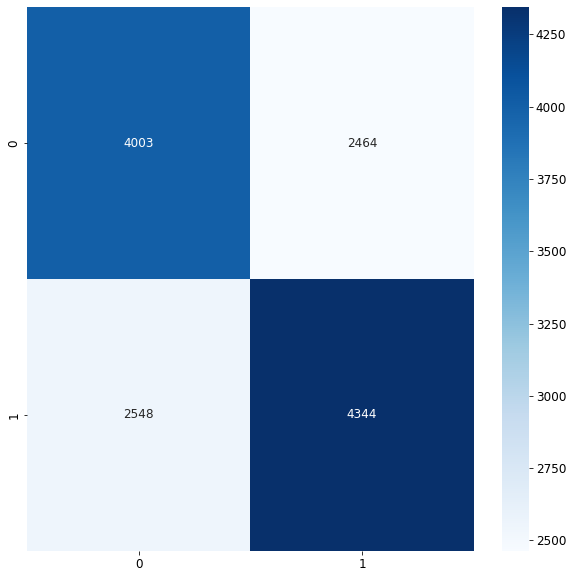

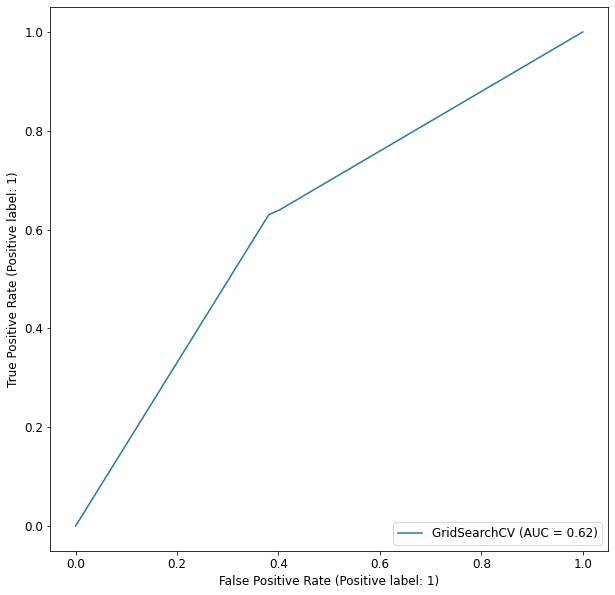

Classifier:  Random Forest
Best hyper parameters : {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 1}


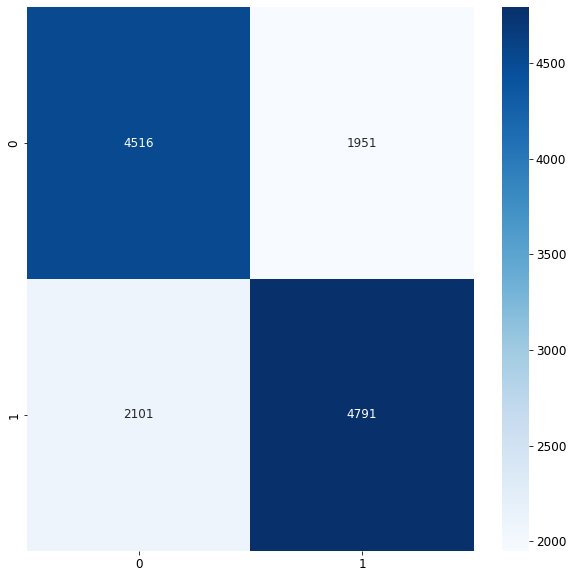

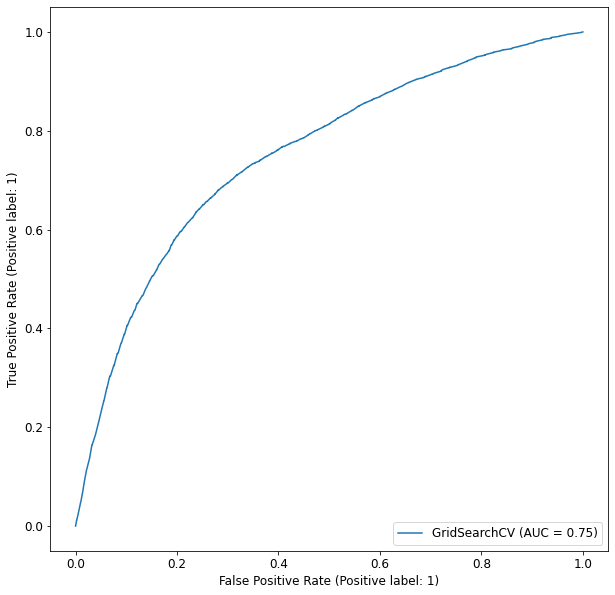

Classifier:  XGBClassifier
Best hyper parameters : {'tree_method': 'hist', 'random_state': 1, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.3}


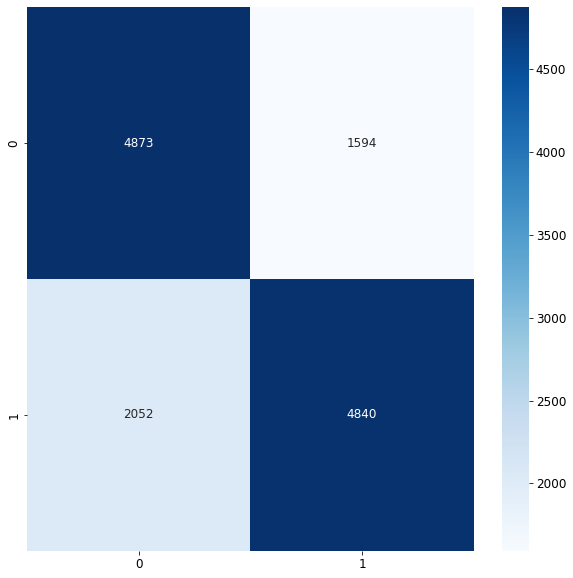

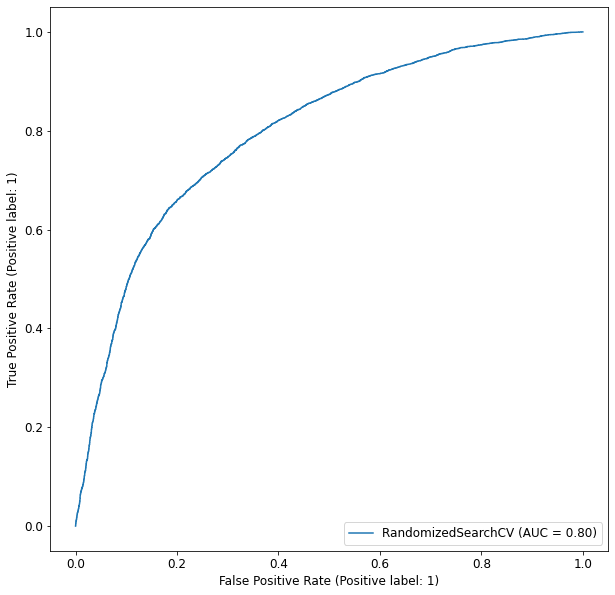

Classifier:  Nearest Neighbors
Best hyper parameters : {'weights': 'uniform', 'p': 1, 'n_neighbors': 7, 'n_jobs': -1, 'algorithm': 'kd_tree'}


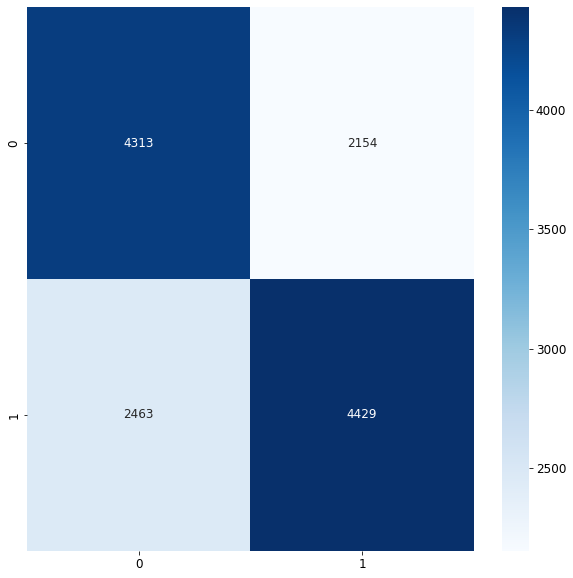

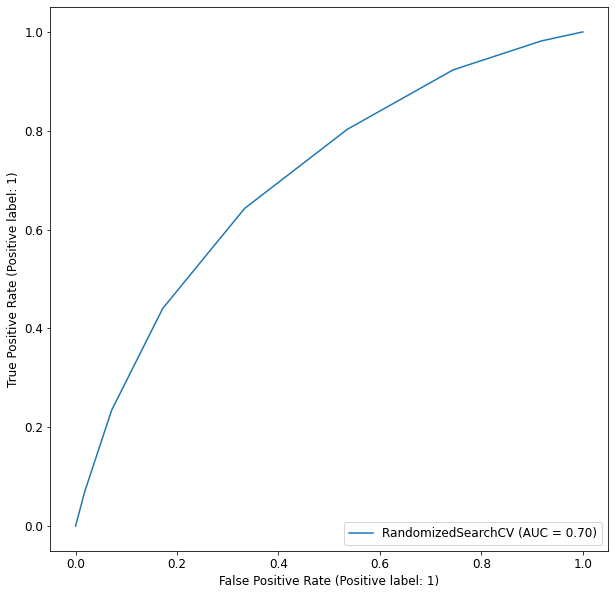

Classifier:  Naive Bayes


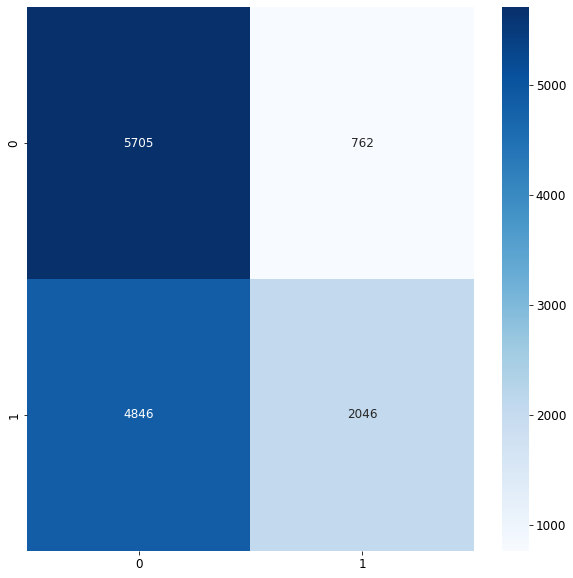

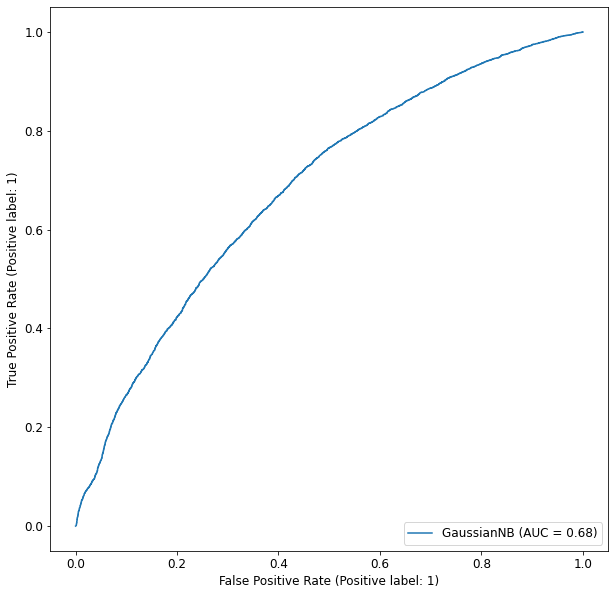

Classifier:  LinearSVC
Best hyper parameters : {'tol': 0.01, 'random_state': 1, 'penalty': 'l1', 'dual': False, 'C': 5}


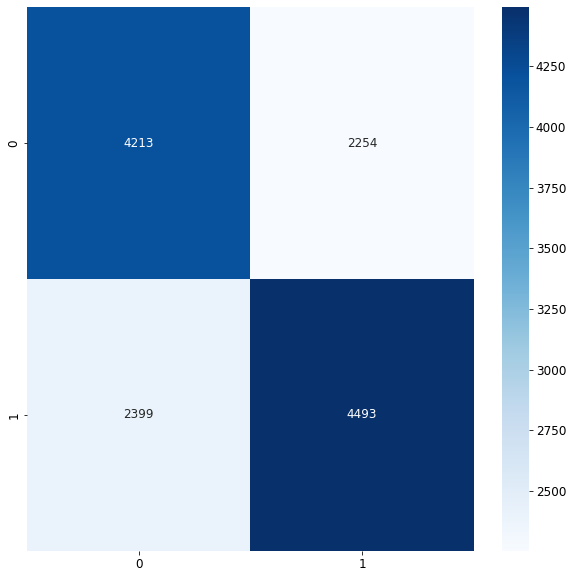

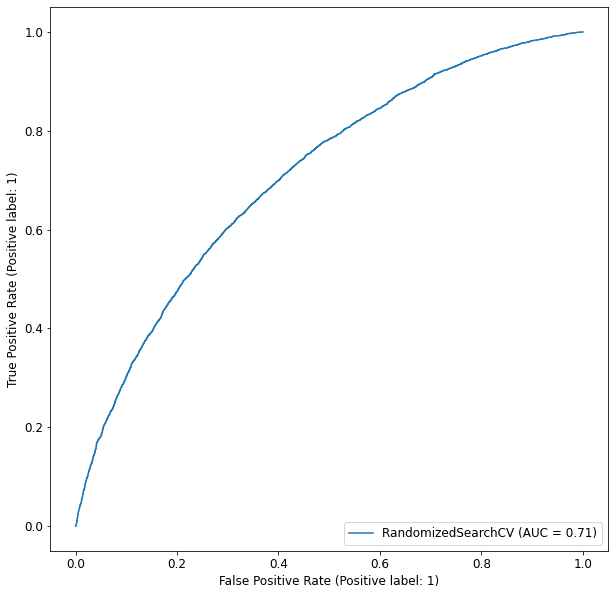

Classifier:  Kmeans
Best hyper parameters : {'algorithm': 'lloyd', 'init': 'k-means++', 'n_clusters': 2, 'random_state': 1}


c:\Users\Giovanni\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,Classifier,Accuracy,Precision,Recall,ROC AUC
F1-Score,,,,,
0.7271,XGBClassifier,0.7271,0.728,0.7279,0.79618
0.6966,Random Forest,0.6967,0.6966,0.6967,0.75084
0.6544,Nearest Neighbors,0.6544,0.6547,0.6548,0.703156
0.6515,LinearSVC,0.6517,0.6516,0.6517,None
0.6246,Decision Tree,0.6248,0.6246,0.6246,0.623686
0.5722,Kmeans,0.583,0.6008,0.5886,None
0.5462,Naive Bayes,0.5802,0.6347,0.5895,0.682865


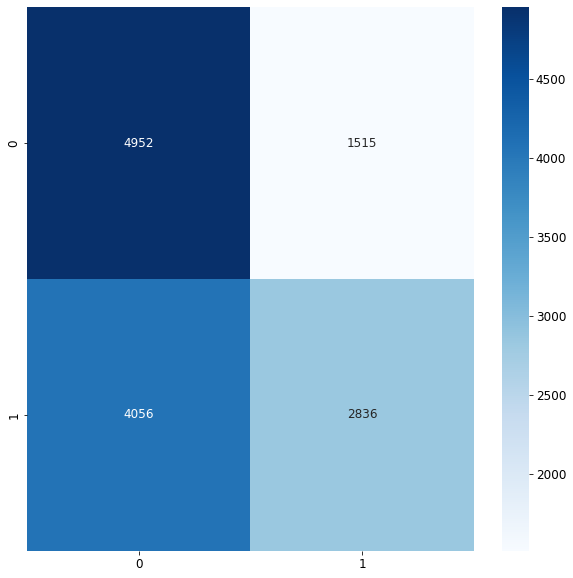

In [63]:
X_train, X_test, y_train, y_test = tt_split(df)

result_matrixes["Plain dataset"] = classification(classifiers, X_train, y_train, X_test, y_test, n_iter=5)
display(result_matrixes["Plain dataset"])

### Cleaned dataset

Classifier:  Decision Tree
Best hyper parameters : {'class_weight': 'balanced', 'criterion': 'entropy', 'random_state': 1, 'splitter': 'random'}


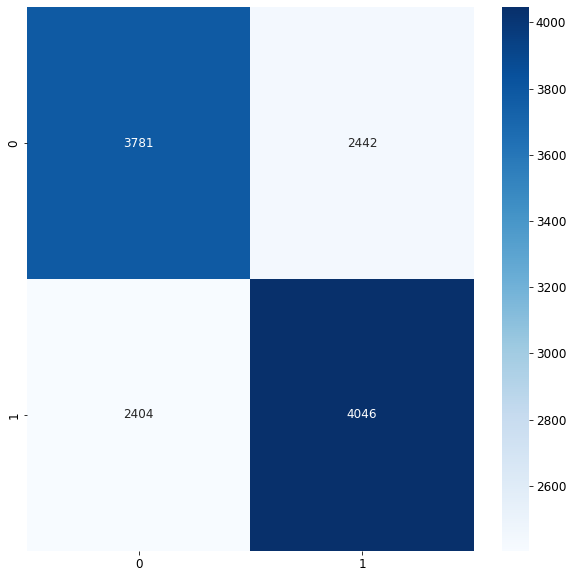

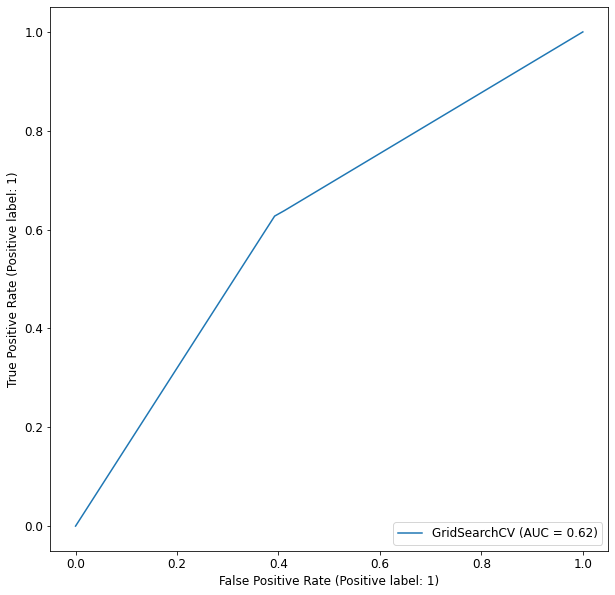

Classifier:  Random Forest
Best hyper parameters : {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 1}


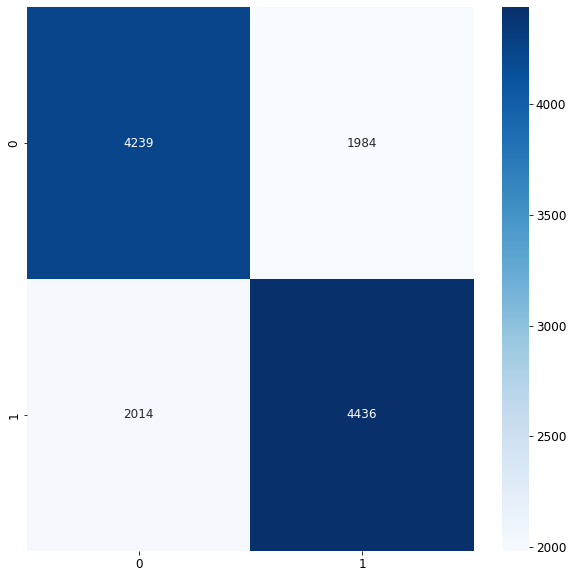

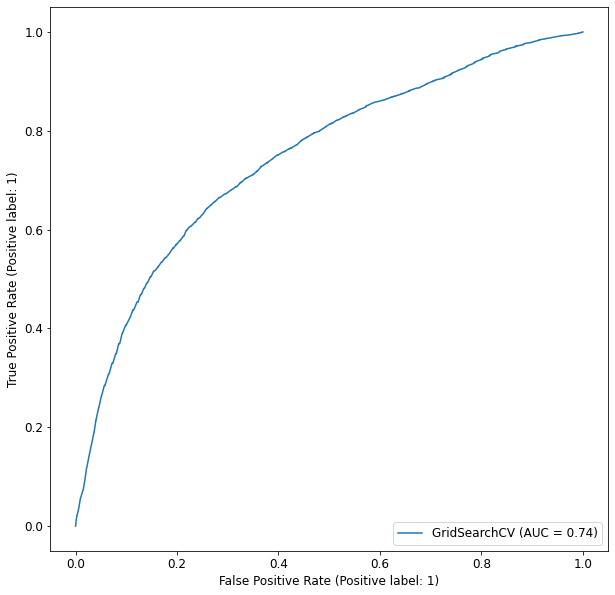

Classifier:  XGBClassifier
Best hyper parameters : {'tree_method': 'approx', 'random_state': 1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.2}


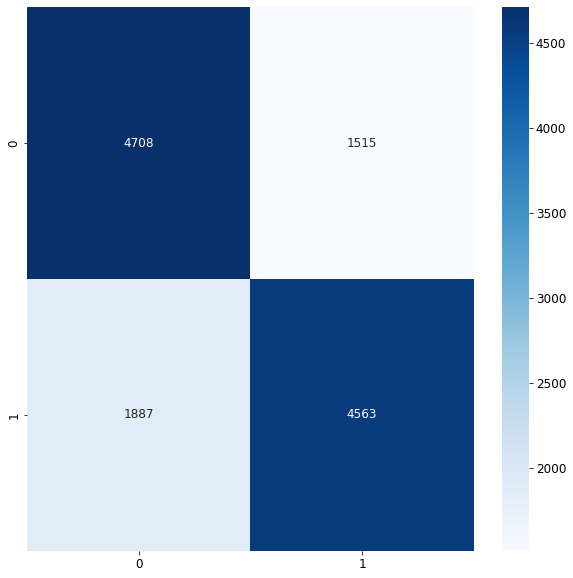

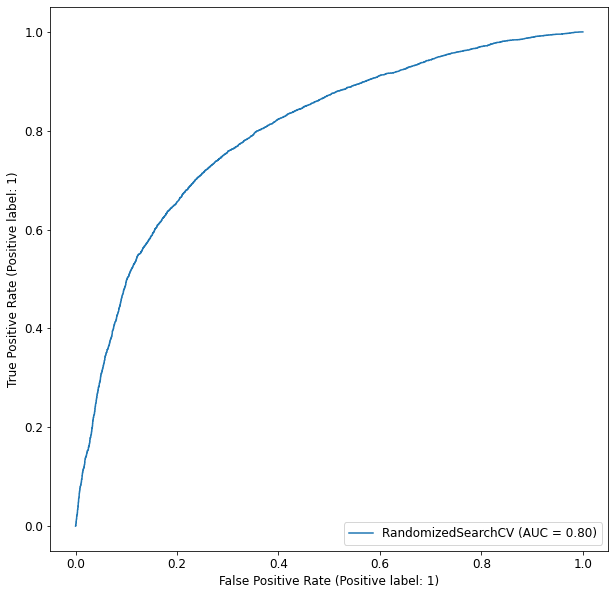

Classifier:  Nearest Neighbors
Best hyper parameters : {'weights': 'uniform', 'p': 2, 'n_neighbors': 9, 'n_jobs': -1, 'algorithm': 'kd_tree'}


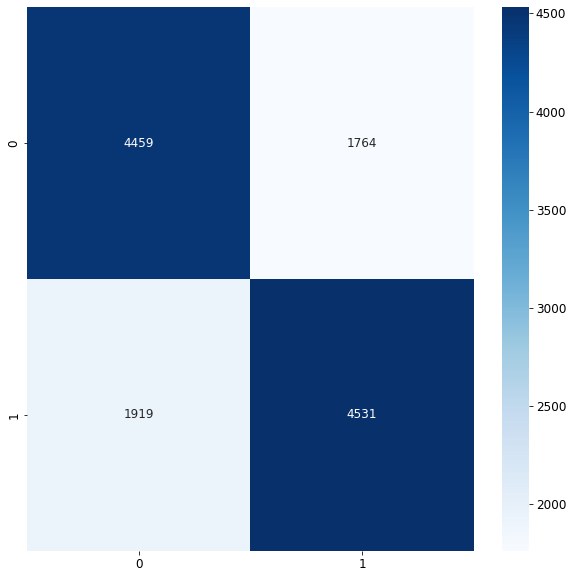

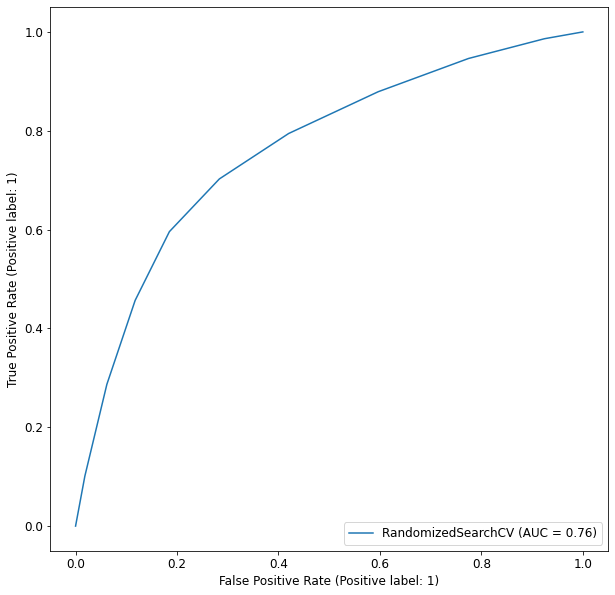

Classifier:  Naive Bayes


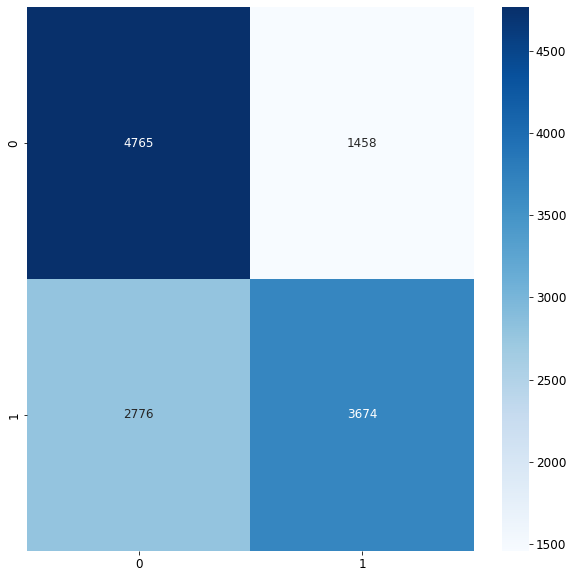

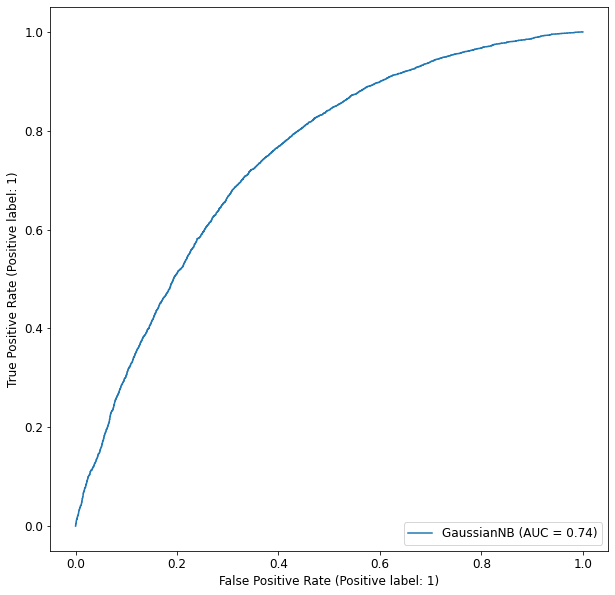

Classifier:  LinearSVC
Best hyper parameters : {'tol': 0.0001, 'random_state': 1, 'penalty': 'l2', 'dual': False, 'C': 1}


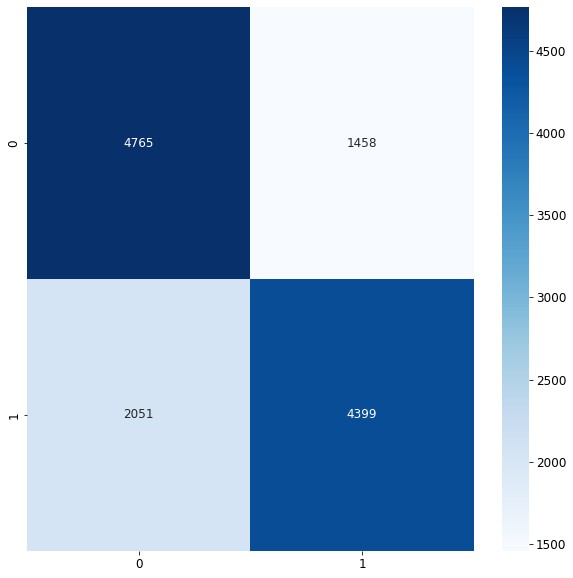

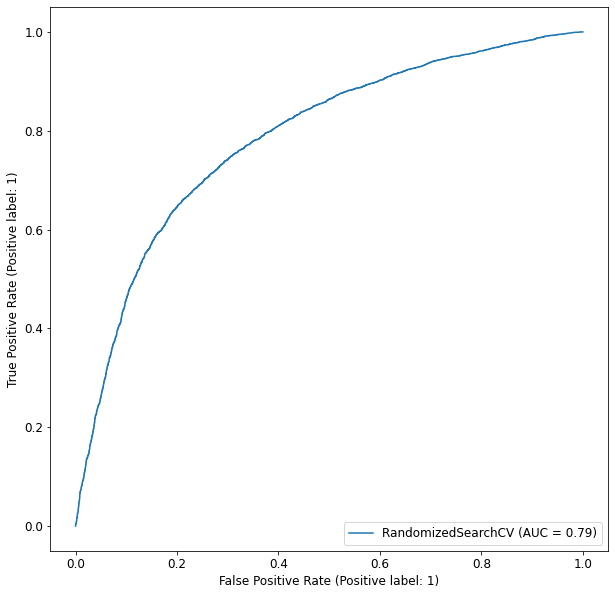

Classifier:  Kmeans
Best hyper parameters : {'algorithm': 'lloyd', 'init': 'k-means++', 'n_clusters': 2, 'random_state': 1}


c:\Users\Giovanni\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,Classifier,Accuracy,Precision,Recall,ROC AUC
F1-Score,,,,,
0.7315,XGBClassifier,0.7316,0.7323,0.732,0.796952
0.7229,LinearSVC,0.7231,0.7251,0.7239,None
0.7094,Nearest Neighbors,0.7094,0.7094,0.7095,0.76174
0.6844,Random Forest,0.6845,0.6844,0.6845,0.744881
0.6634,Naive Bayes,0.6659,0.6739,0.6677,0.741708
0.6174,Decision Tree,0.6176,0.6175,0.6174,0.617216
0.3306,Kmeans,0.343,0.3297,0.3407,None


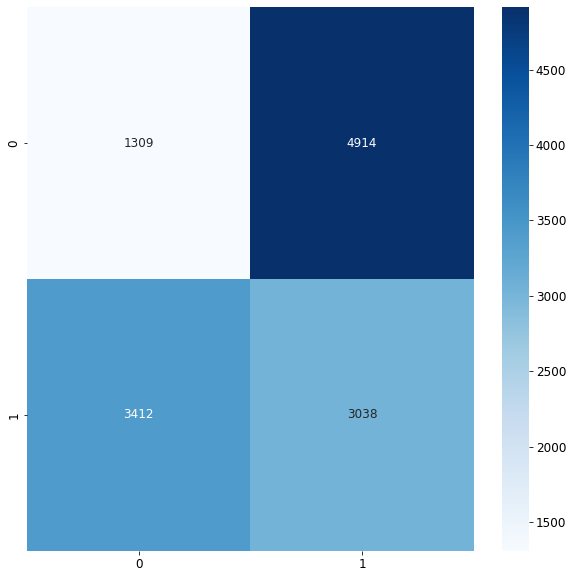

In [64]:
X_train, X_test, y_train, y_test = tt_split(df_cleaned)

result_matrixes["Cleaned dataset"] = classification(classifiers, X_train, y_train, X_test, y_test, n_iter=5)
display(result_matrixes["Cleaned dataset"])

### Cleaned dataset without smoke and alcool features

Classifier:  Decision Tree
Best hyper parameters : {'class_weight': 'balanced', 'criterion': 'entropy', 'random_state': 1, 'splitter': 'best'}


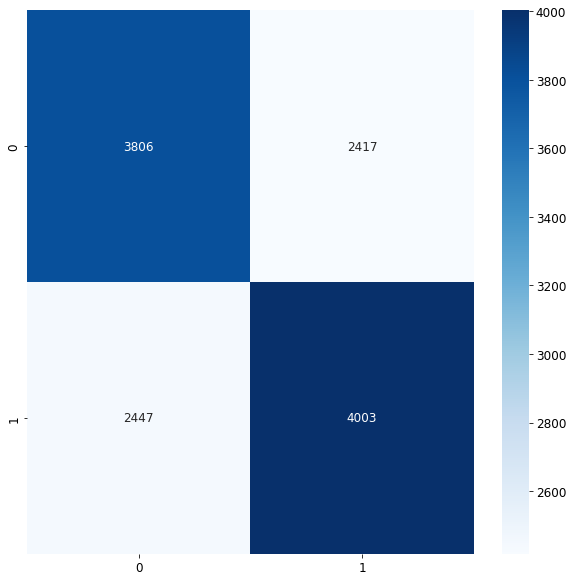

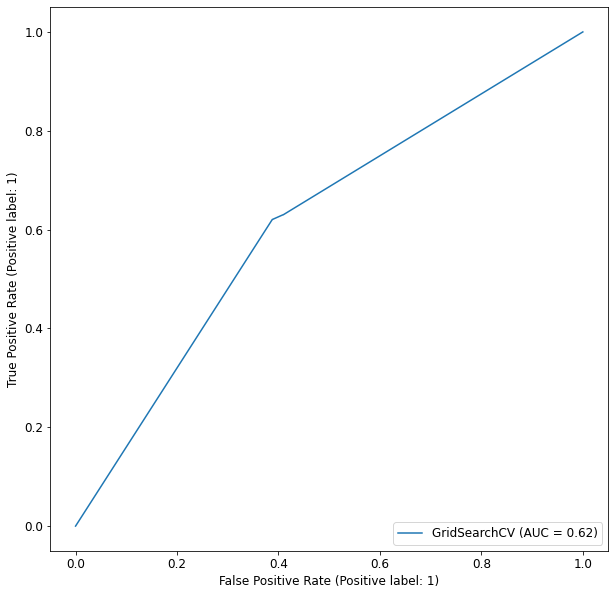

Classifier:  Random Forest
Best hyper parameters : {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 1}


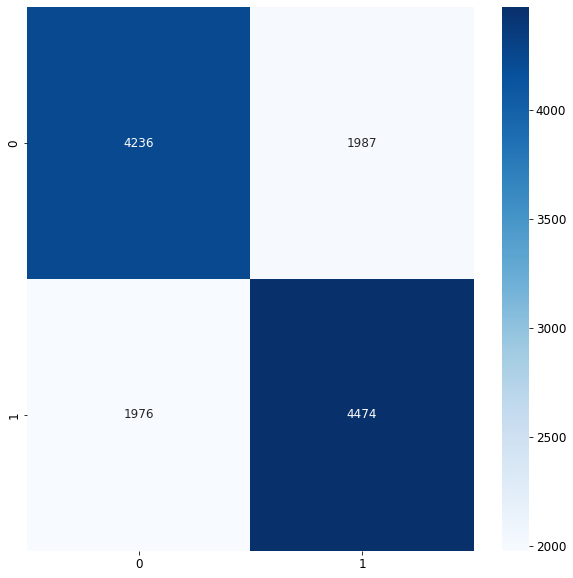

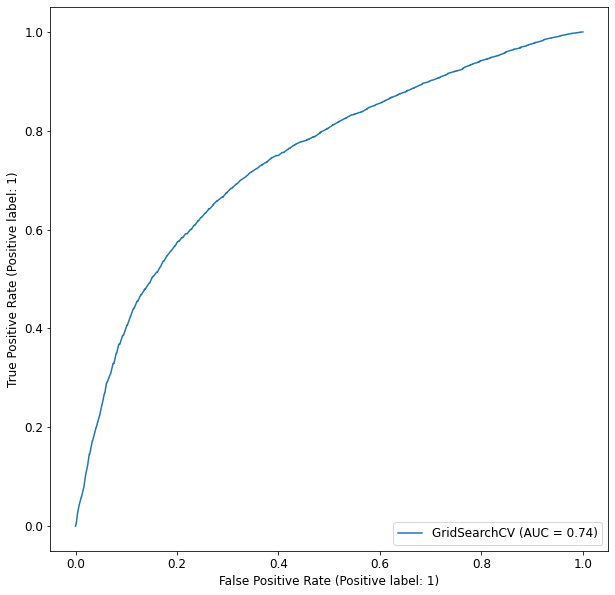

Classifier:  XGBClassifier
Best hyper parameters : {'tree_method': 'approx', 'random_state': 1, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 8, 'learning_rate': 0.01}


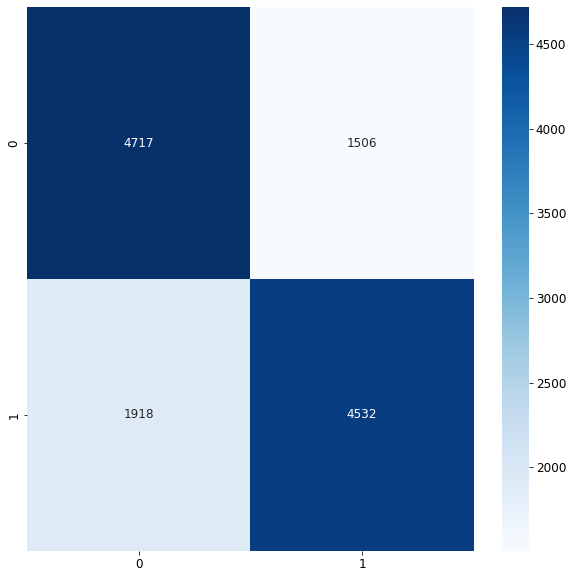

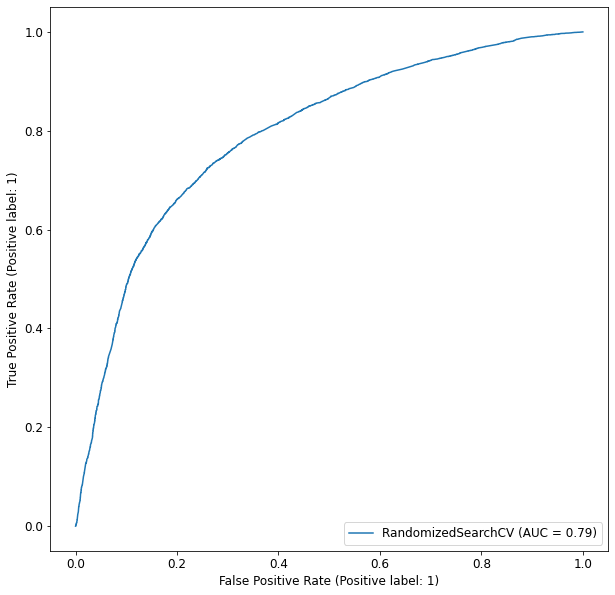

Classifier:  Nearest Neighbors
Best hyper parameters : {'weights': 'uniform', 'p': 2, 'n_neighbors': 7, 'n_jobs': -1, 'algorithm': 'ball_tree'}


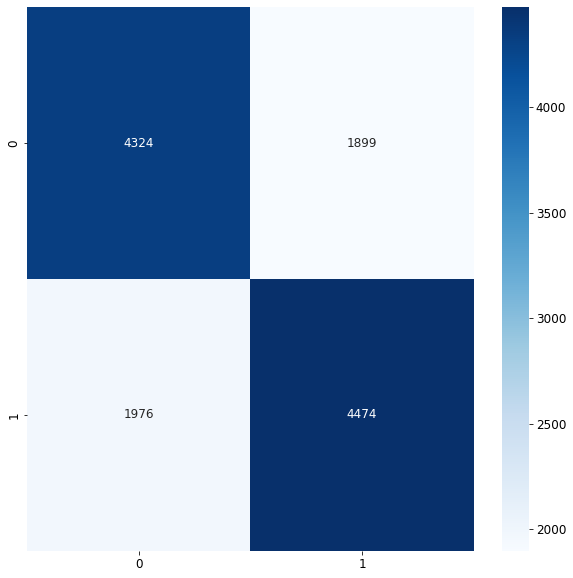

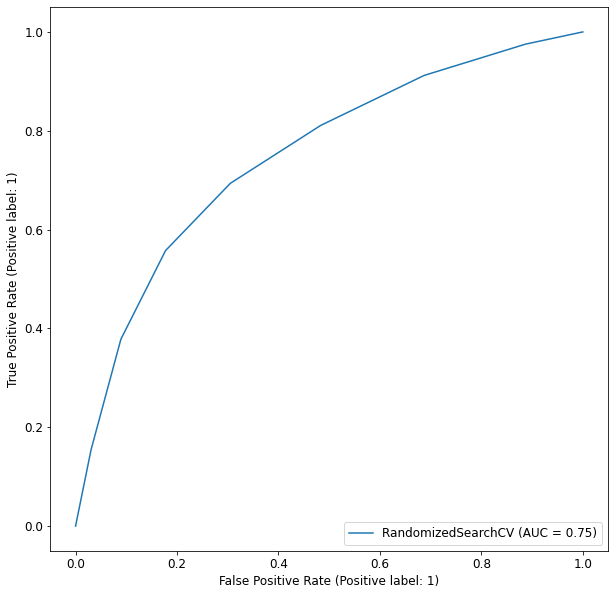

Classifier:  Naive Bayes


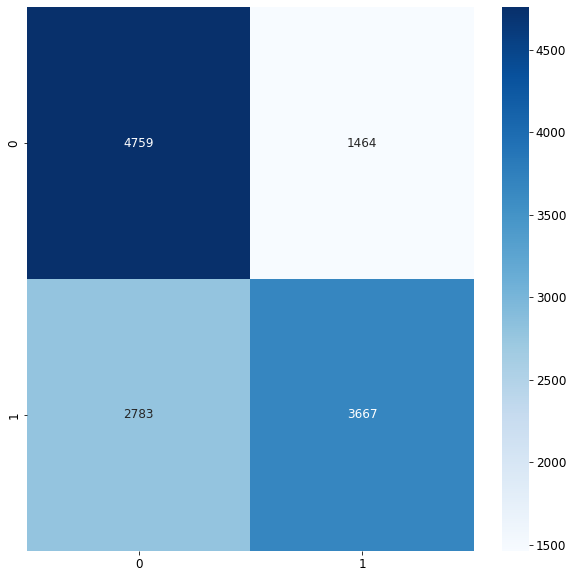

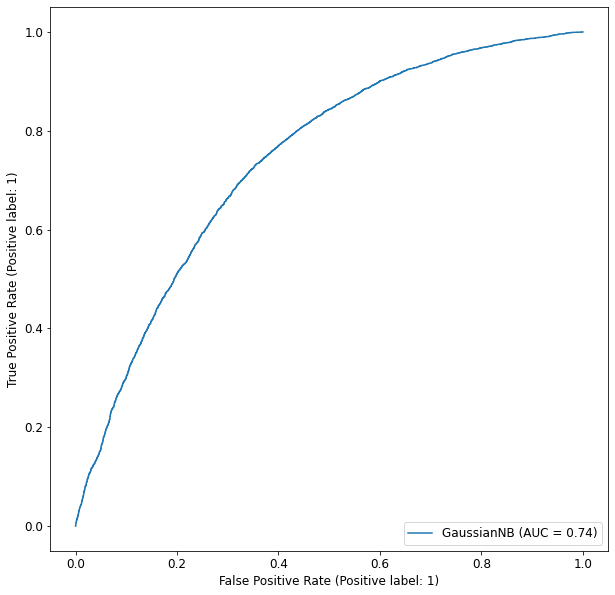

Classifier:  LinearSVC
Best hyper parameters : {'tol': 0.01, 'random_state': 1, 'penalty': 'l2', 'dual': False, 'C': 5}


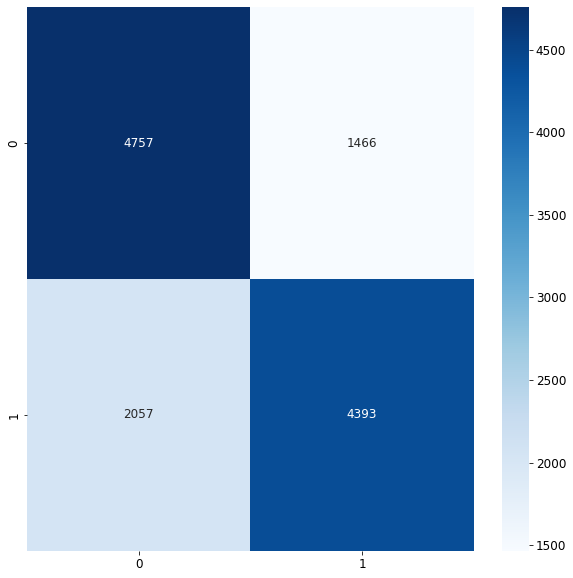

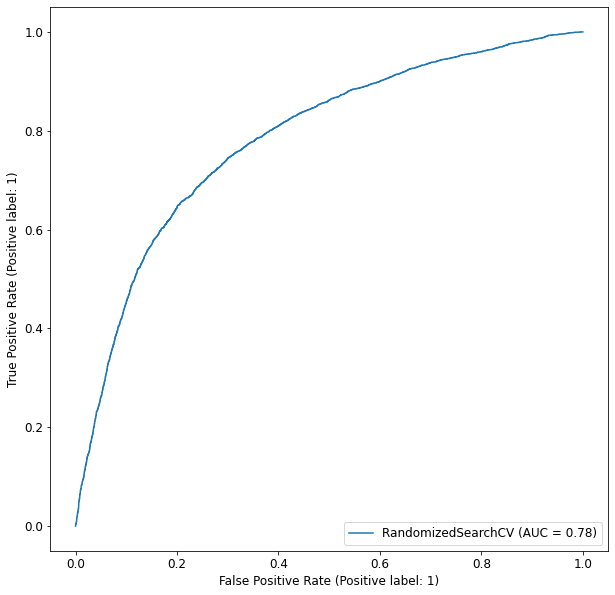

Classifier:  Kmeans
Best hyper parameters : {'algorithm': 'lloyd', 'init': 'k-means++', 'n_clusters': 2, 'random_state': 1}


c:\Users\Giovanni\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,Classifier,Accuracy,Precision,Recall,ROC AUC
F1-Score,,,,,
0.7298,XGBClassifier,0.7298,0.7308,0.7303,0.793814
0.7218,LinearSVC,0.722,0.724,0.7228,None
0.6942,Nearest Neighbors,0.6942,0.6942,0.6942,0.748907
0.6872,Random Forest,0.6873,0.6872,0.6872,0.742819
0.6624,Naive Bayes,0.6649,0.6728,0.6666,0.741463
0.6161,Decision Tree,0.6162,0.6161,0.6161,0.615129
0.3304,Kmeans,0.3431,0.3295,0.3407,None


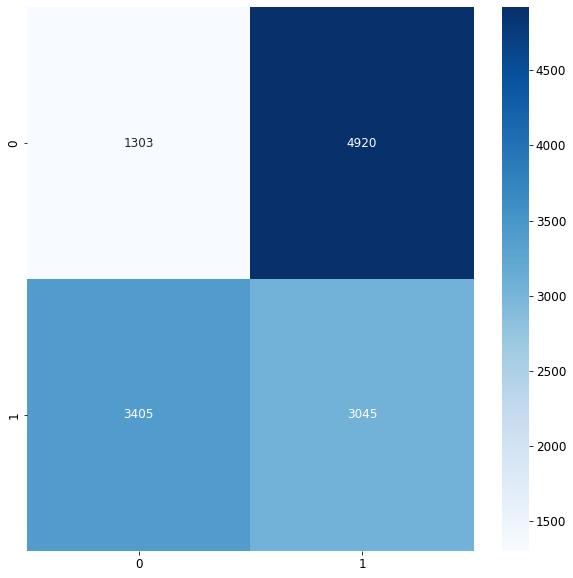

In [65]:
X_train, X_test, y_train, y_test = tt_split(df_cleaned[["age", "gender", "height", "weight", "BMI", "ap_hi", "ap_lo", "cholesterol_1", "cholesterol_2", "cholesterol_3", "gluc_1", "gluc_2", "gluc_3", "active", "cardio"]])

result_matrixes["Cleaned dataset without smoke and alcool features"] = classification(classifiers, X_train, y_train, X_test, y_test, n_iter=5)
display(result_matrixes["Cleaned dataset without smoke and alcool features"])

### Obese/overweight dataset

Classifier:  Decision Tree
Best hyper parameters : {'class_weight': 'balanced', 'criterion': 'entropy', 'random_state': 1, 'splitter': 'random'}


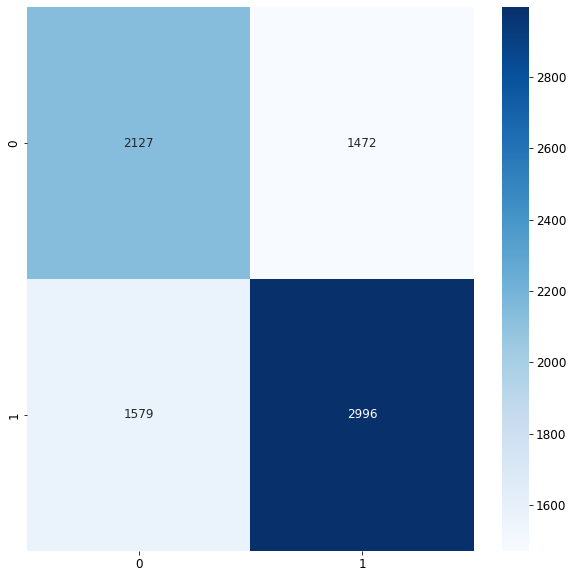

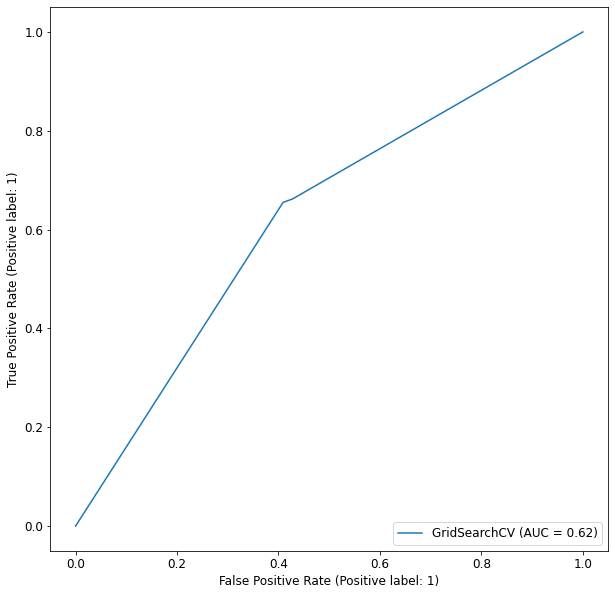

Classifier:  Random Forest
Best hyper parameters : {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 1}


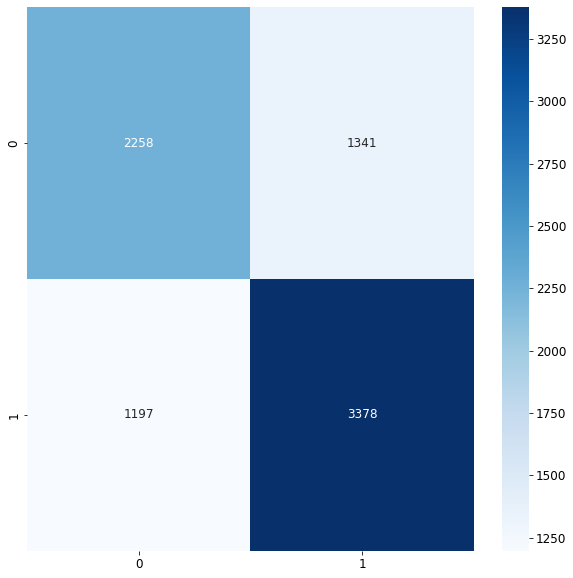

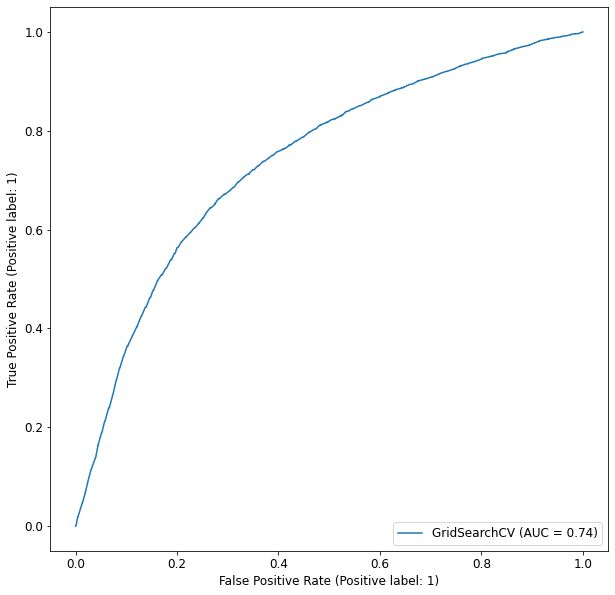

Classifier:  XGBClassifier
Best hyper parameters : {'tree_method': 'exact', 'random_state': 1, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1}


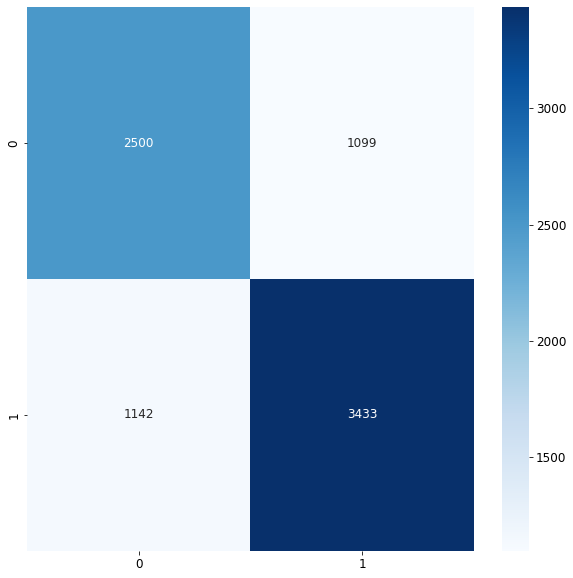

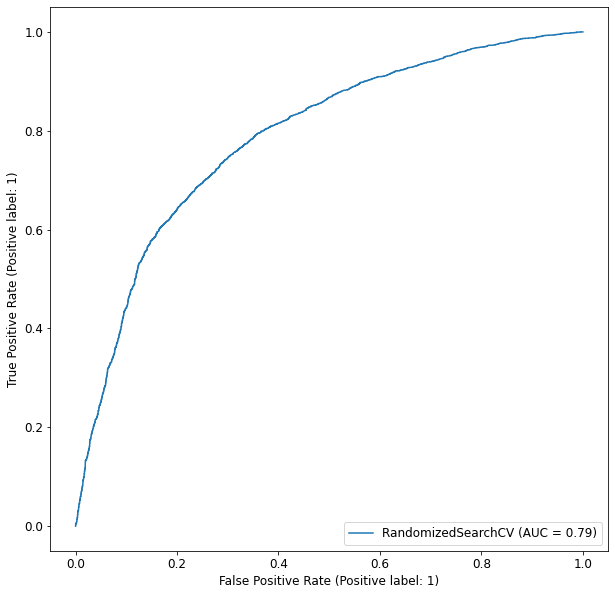

Classifier:  Nearest Neighbors
Best hyper parameters : {'weights': 'distance', 'p': 1, 'n_neighbors': 9, 'n_jobs': -1, 'algorithm': 'ball_tree'}


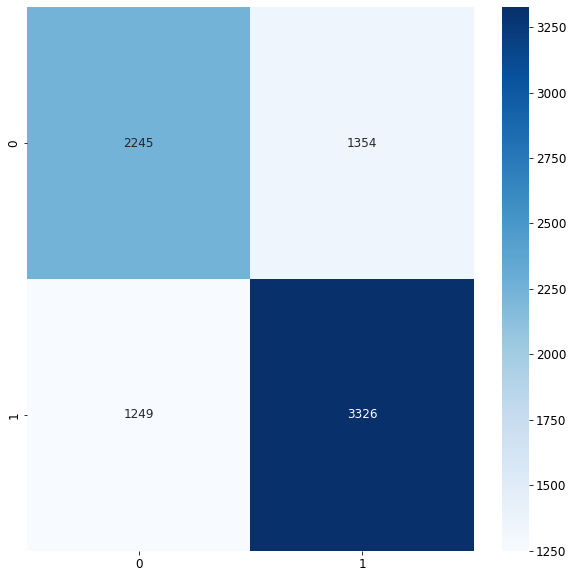

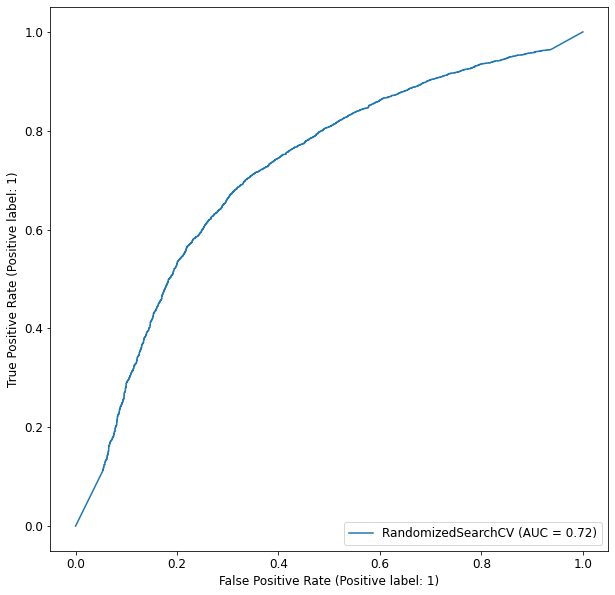

Classifier:  Naive Bayes


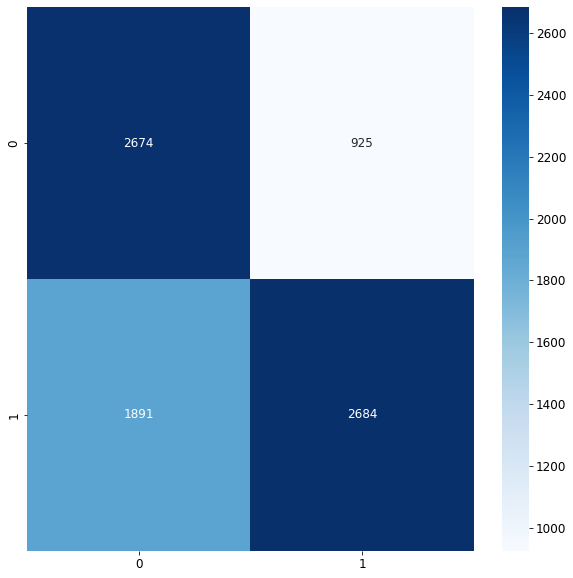

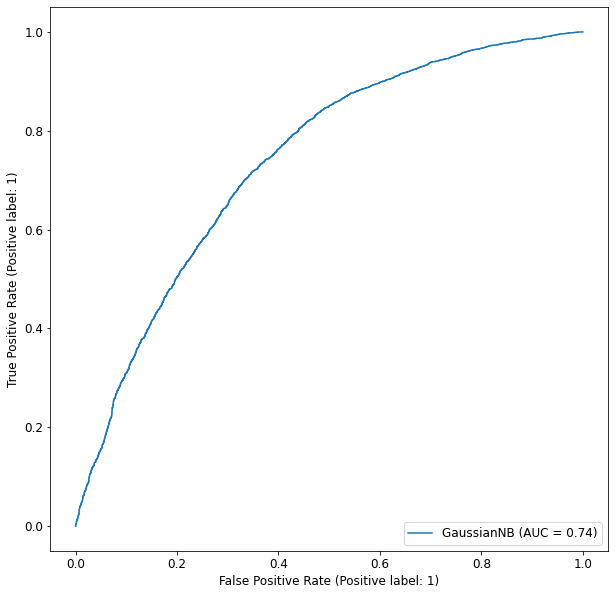

Classifier:  LinearSVC
Best hyper parameters : {'tol': 0.01, 'random_state': 1, 'penalty': 'l1', 'dual': False, 'C': 1}


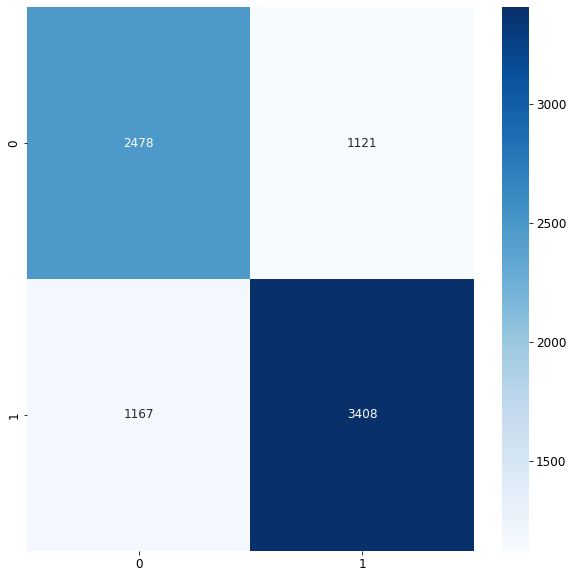

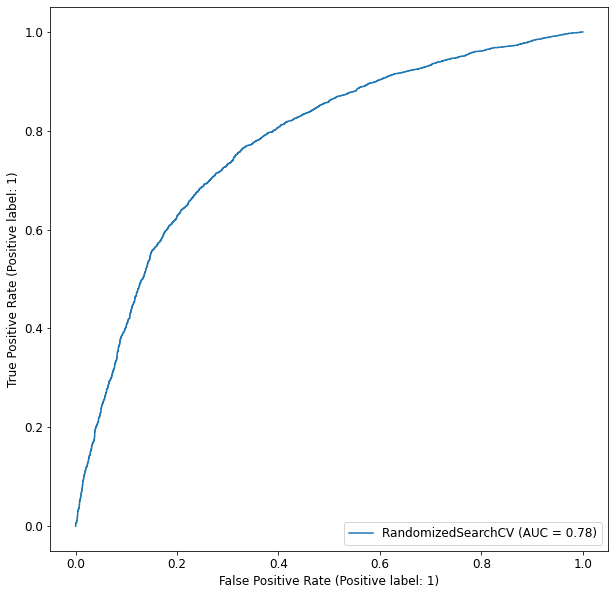

Classifier:  Kmeans
Best hyper parameters : {'algorithm': 'lloyd', 'init': 'k-means++', 'n_clusters': 2, 'random_state': 1}


c:\Users\Giovanni\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,Classifier,Accuracy,Precision,Recall,ROC AUC
F1-Score,,,,,
0.7222,XGBClassifier,0.7258,0.722,0.7225,0.78737
0.7164,LinearSVC,0.7201,0.7162,0.7167,None
0.6836,Random Forest,0.6895,0.6847,0.6829,0.738937
0.6759,Nearest Neighbors,0.6816,0.6766,0.6754,0.717481
0.6560,Kmeans,0.6568,0.6782,0.6723,None
0.6555,Naive Bayes,0.6555,0.6647,0.6648,0.739343
0.6225,Decision Tree,0.6267,0.6222,0.6229,0.621801


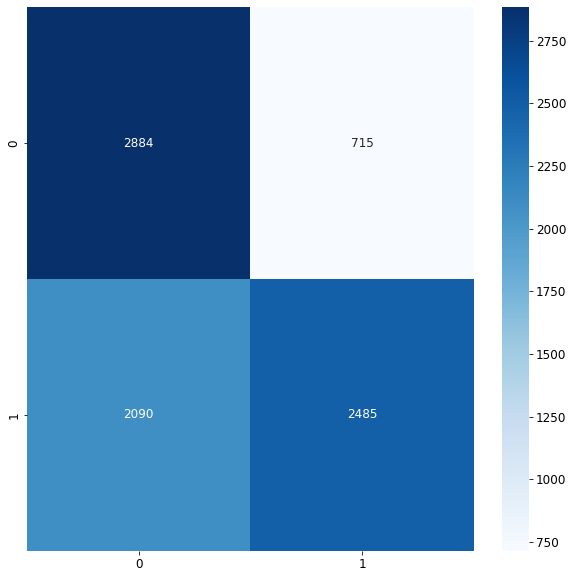

In [66]:
df_obese = df_cleaned[["age", "gender", "height", "weight", "BMI", "ap_hi", "ap_lo", "cholesterol_1", "cholesterol_2", "cholesterol_3", "gluc_1", "gluc_2", "gluc_3", "active", "cardio"]]
df_obese = df_obese.loc[BMI >= 25]

X_train, X_test, y_train, y_test = tt_split(df_obese)

result_matrixes["Obese/overweight dataset"] = classification(classifiers, X_train, y_train, X_test, y_test, n_iter=5)
display(result_matrixes["Obese/overweight dataset"])

### Final results

In [67]:
for data,result in result_matrixes.items():
    display(data, result)

'Plain dataset'

,Classifier,Accuracy,Precision,Recall,ROC AUC
F1-Score,,,,,
0.7271,XGBClassifier,0.7271,0.728,0.7279,0.79618
0.6966,Random Forest,0.6967,0.6966,0.6967,0.75084
0.6544,Nearest Neighbors,0.6544,0.6547,0.6548,0.703156
0.6515,LinearSVC,0.6517,0.6516,0.6517,None
0.6246,Decision Tree,0.6248,0.6246,0.6246,0.623686
0.5722,Kmeans,0.583,0.6008,0.5886,None
0.5462,Naive Bayes,0.5802,0.6347,0.5895,0.682865


'Cleaned dataset'

,Classifier,Accuracy,Precision,Recall,ROC AUC
F1-Score,,,,,
0.7315,XGBClassifier,0.7316,0.7323,0.732,0.796952
0.7229,LinearSVC,0.7231,0.7251,0.7239,None
0.7094,Nearest Neighbors,0.7094,0.7094,0.7095,0.76174
0.6844,Random Forest,0.6845,0.6844,0.6845,0.744881
0.6634,Naive Bayes,0.6659,0.6739,0.6677,0.741708
0.6174,Decision Tree,0.6176,0.6175,0.6174,0.617216
0.3306,Kmeans,0.343,0.3297,0.3407,None


'Cleaned dataset without smoke and alcool features'

,Classifier,Accuracy,Precision,Recall,ROC AUC
F1-Score,,,,,
0.7298,XGBClassifier,0.7298,0.7308,0.7303,0.793814
0.7218,LinearSVC,0.722,0.724,0.7228,None
0.6942,Nearest Neighbors,0.6942,0.6942,0.6942,0.748907
0.6872,Random Forest,0.6873,0.6872,0.6872,0.742819
0.6624,Naive Bayes,0.6649,0.6728,0.6666,0.741463
0.6161,Decision Tree,0.6162,0.6161,0.6161,0.615129
0.3304,Kmeans,0.3431,0.3295,0.3407,None


'Obese/overweight dataset'

,Classifier,Accuracy,Precision,Recall,ROC AUC
F1-Score,,,,,
0.7222,XGBClassifier,0.7258,0.722,0.7225,0.78737
0.7164,LinearSVC,0.7201,0.7162,0.7167,None
0.6836,Random Forest,0.6895,0.6847,0.6829,0.738937
0.6759,Nearest Neighbors,0.6816,0.6766,0.6754,0.717481
0.6560,Kmeans,0.6568,0.6782,0.6723,None
0.6555,Naive Bayes,0.6555,0.6647,0.6648,0.739343
0.6225,Decision Tree,0.6267,0.6222,0.6229,0.621801
